In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import os
import sys
from collections import Counter
import gget
import scipy
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfTransformer
import itertools

import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from importlib import reload

# local imports
sys.path.append("./")
import utils

In [2]:
def min_max(v):
    return (v - v.min()) / (v.max() - v.min())

# Load our data

In [3]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/anndata.tabula.h5ad"

adata = sc.read_h5ad(fpath)
adata

AnnData object with n_obs × n_vars = 35830 × 14599
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

In [4]:
adata.var_names_make_unique()

# annotate all labels
adata.obs['group'] = np.where(adata.obs['cluster_name'].isna(), "C5", adata.obs['cluster_name'])
adata.obs['group'] = np.where(adata.obs['celltype'] == 'HSC', "C6", adata.obs['group'])

In [5]:
adata.obs['set'].value_counts(dropna=False)

set
ref_data    27346
our_data     8484
Name: count, dtype: int64

In [6]:
adata.obs['group'].value_counts(dropna=False)

group
C5    26586
C1     5565
C2     1449
C3      911
C6      760
C4      559
Name: count, dtype: int64

In [7]:
adata.obs['celltype'].value_counts(dropna=False)

celltype
FB     26586
NaN     8484
HSC      760
Name: count, dtype: int64

In [8]:
print(adata.obs['organ_tissue'].value_counts(dropna=False))

adata.obs['organ_tissue'].value_counts(dropna=False).index

organ_tissue
NaN                8484
Fat                8459
Vasculature        5867
Bladder            5557
Thymus             3924
Trachea            1239
Large_Intestine     953
Bone_Marrow         617
Tongue              251
Prostate            223
Small_Intestine     113
Spleen               73
Blood                70
Name: count, dtype: int64


CategoricalIndex([nan, 'Fat', 'Vasculature', 'Bladder', 'Thymus', 'Trachea',
                  'Large_Intestine', 'Bone_Marrow', 'Tongue', 'Prostate',
                  'Small_Intestine', 'Spleen', 'Blood'],
                 categories=['Bladder', 'Blood', 'Bone_Marrow', 'Fat', ..., 'Thymus', 'Tongue', 'Trachea', 'Vasculature'], ordered=False, dtype='category', name='organ_tissue')

# distances on marker genes

X.shape=(16968, 206)
C1
C2
C3
C4
C5


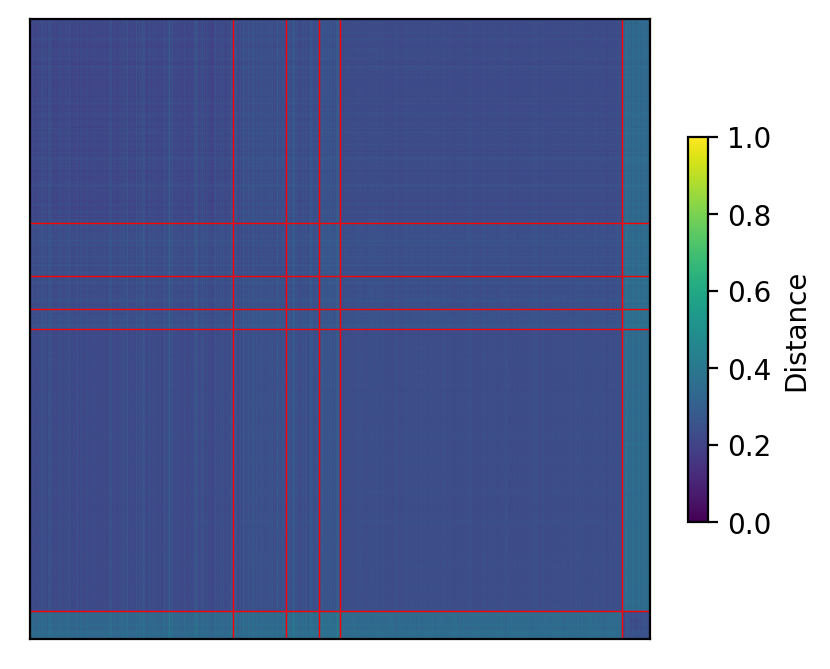

In [9]:
metric = 'euclidean'
pdf = utils.get_stacked_cell_data(adata, genes='marker')

X = pdf.X
print(f"{X.shape=}")

# make distance matrix
D = scipy.spatial.distance.pdist(X, metric=metric)
D = min_max(D)
D = scipy.spatial.distance.squareform(D)
D = pd.DataFrame(D, index=pdf.obs.index, 
                 columns=pdf.obs.index)


sorted_idx = pdf.obs.sort_values(by='group').index
group_labels = pdf.obs['group'].sort_values().values
label_switch_idx = np.where(group_labels[:-1] != group_labels[1:])[0]
group_labels_unique = np.unique(group_labels)

D = D[sorted_idx]
D = D.reindex(sorted_idx)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

plt.imshow(D)
plt.colorbar(shrink=0.5, label='Distance')
plt.xticks([], [])
plt.yticks([], [])

for i, idx_val in enumerate(label_switch_idx):
    print(group_labels_unique[i])
    plt.axvline(x=idx_val, c='r', lw=0.5)
    plt.axhline(y=idx_val, c='r', lw=0.5)

Text(0.5, 1.0, 'Mean Distance')

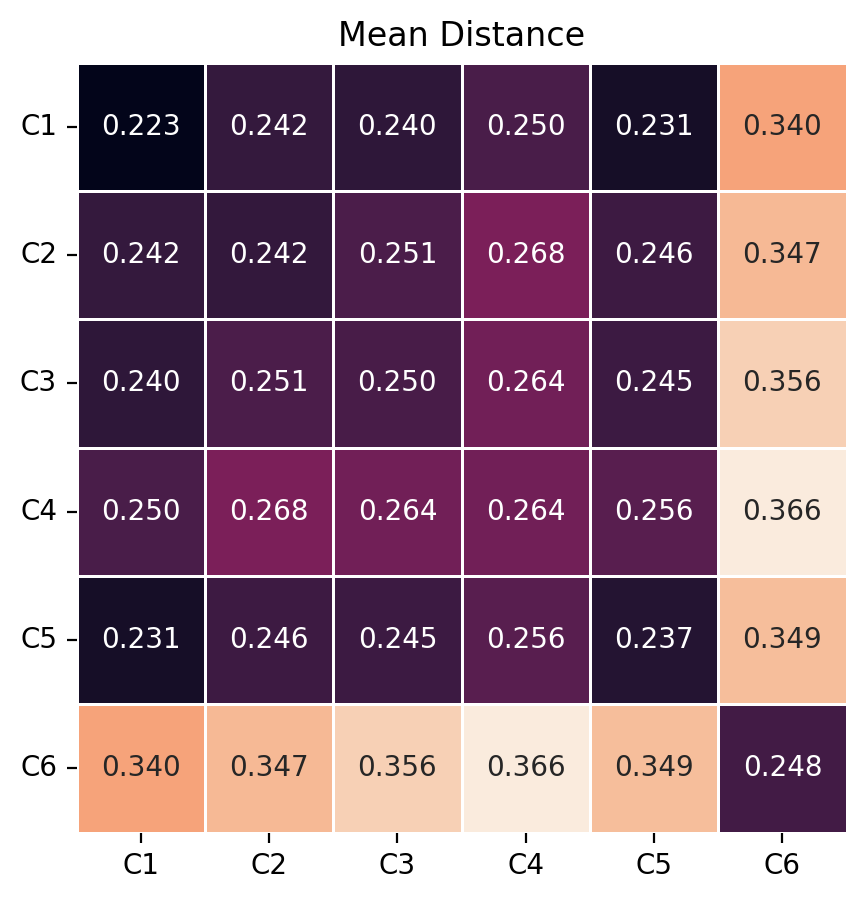

In [10]:
# average distances
res = []

for i_name, group_i in pdf.obs.groupby('group'):
    for j_name, group_j in pdf.obs.groupby('group'):
        i_idx = group_i.index
        j_idx = group_j.index

        mean_dist = np.mean(D.loc[i_idx][j_idx].to_numpy())

        row = {
            'i_name' : i_name,
            'j_name' : j_name,
            'mean_dist' : mean_dist,
        }

        res.append(row)
        
res = pd.DataFrame(res)
res = pd.pivot_table(res, 
                     index='i_name', 
                     columns='j_name', 
                     values='mean_dist')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(res, square=True,
            linewidth=0.5,
            annot=True,
            fmt=".3f",
            cbar=False)

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)
plt.title("Mean Distance")

In [11]:
# break

# distribution of distances


X.shape=(16968, 206)


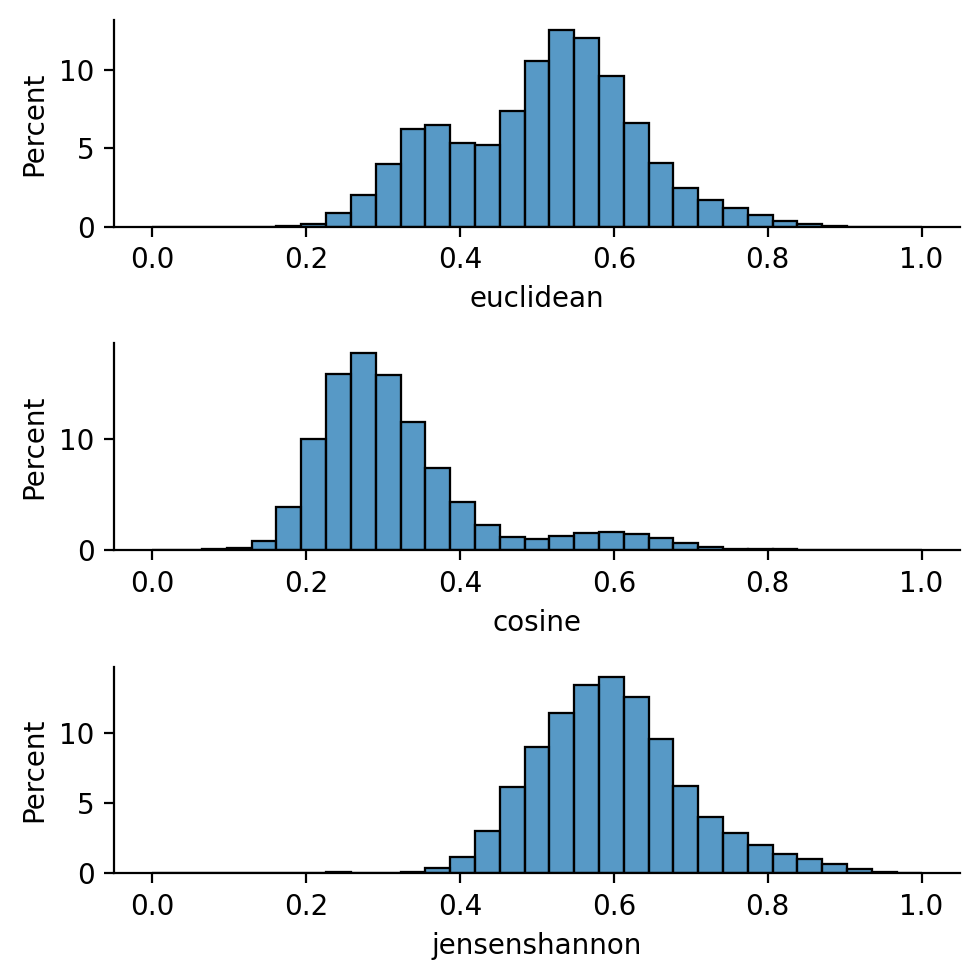

In [12]:
metrics = [
    'euclidean',
    'cosine',
    'jensenshannon',
]

sample_size = 1000

pdf = utils.get_stacked_cell_data(adata, genes='marker')

X = pdf.X
print(f"{X.shape=}")
Xhat = preprocessing.minmax_scale(X, feature_range=(0, 1), axis=1)

sample_index = np.random.choice(list(range(len(Xhat))), 
                                sample_size, replace=False)

fig, axs = plt.subplots(3, 1)

for i, metric in enumerate(metrics):
    # make distance matrix
    D = scipy.spatial.distance.pdist(Xhat[sample_index, :], metric=metric)
    D = min_max(np.ravel(D))
    
    sns.histplot(x=D, 
                 bins=31,
                 stat='percent',
                 ax=axs[i])

    axs[i].set_xlabel(metric)
    
sns.despine()
plt.tight_layout()

# PCA on marker genes

In [13]:
pdf = utils.get_stacked_cell_data(adata, genes='marker')
pdf

View of AnnData object with n_obs × n_vars = 16968 × 206
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'

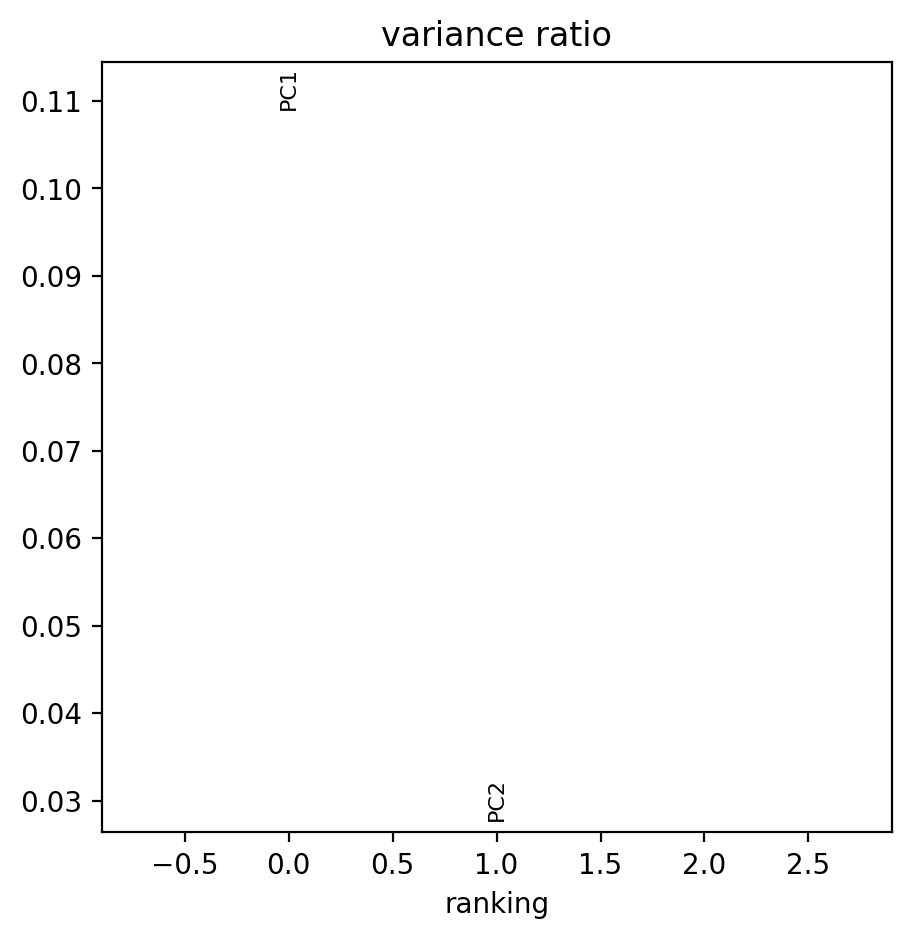

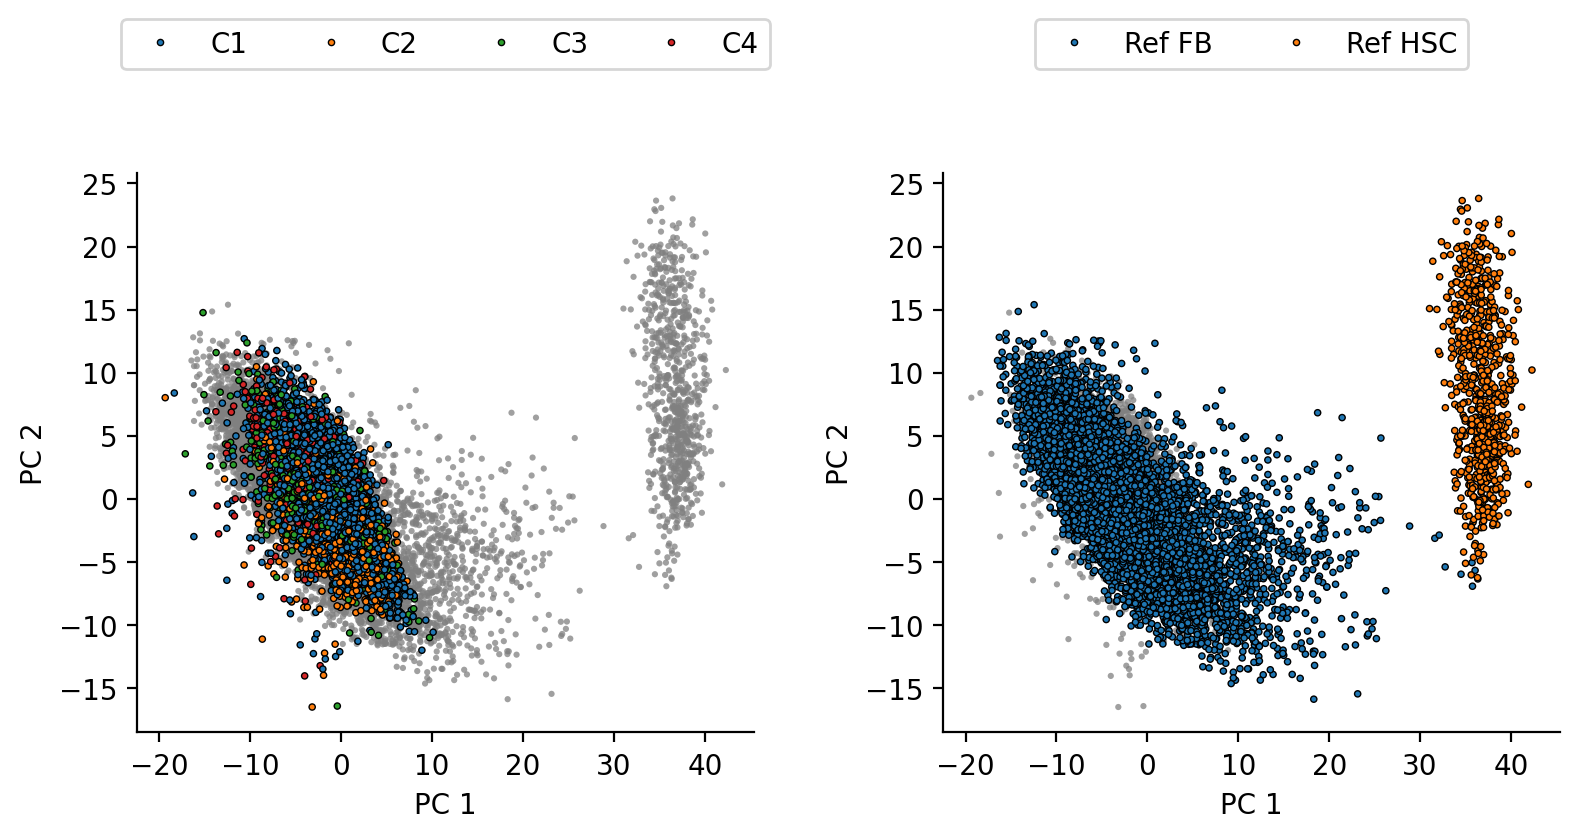

In [14]:
# conduct PCA
pdf = utils.get_stacked_cell_data(adata, genes='marker')
n_comps = 2
sc.tl.pca(pdf, n_comps=n_comps, 
          use_highly_variable=False)

sc.pl.pca_variance_ratio(pdf, n_pcs=n_comps)

pdf.obs['PC 1'] = pdf.obsm['X_pca'][:, 0]
pdf.obs['PC 2'] = pdf.obsm['X_pca'][:, 1]

label_map = {
    'C1' : 'C1',
    'C2' : 'C2',
    'C3' : 'C3',
    'C4' : 'C4',
    'C5' : 'Ref FB',
    'C6' : 'Ref HSC',
}

pdf.obs['group_label'] = pdf.obs['group'].map(label_map)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4.5

fig, axs = plt.subplots(1, 2)

for i, (data_set, group) in enumerate(pdf.obs.groupby('set')):
    sns.scatterplot(data=pdf.obs,
                    x='PC 1',
                    y='PC 2',
                    s=5,
                    ec='none',
                    color='grey',
                    zorder=0,
                    alpha=0.75,
                    linewidths=0.5,
                    ax=axs[i])

    sns.scatterplot(data=group,
                    x='PC 1',
                    y='PC 2',
                    s=5,
                    ec='k',
                    hue='group_label',
                    zorder=1,
                    linewidths=0.5,
                    ax=axs[i])
    
    # structure the legend
    n_groups = group['group_label'].nunique()
    sns.move_legend(axs[i],
                    title="",
                    loc='upper center',
                    ncols=n_groups,
                    bbox_to_anchor=(0.5, 1.3),
                   )

sns.despine()
plt.tight_layout()
plt.show()

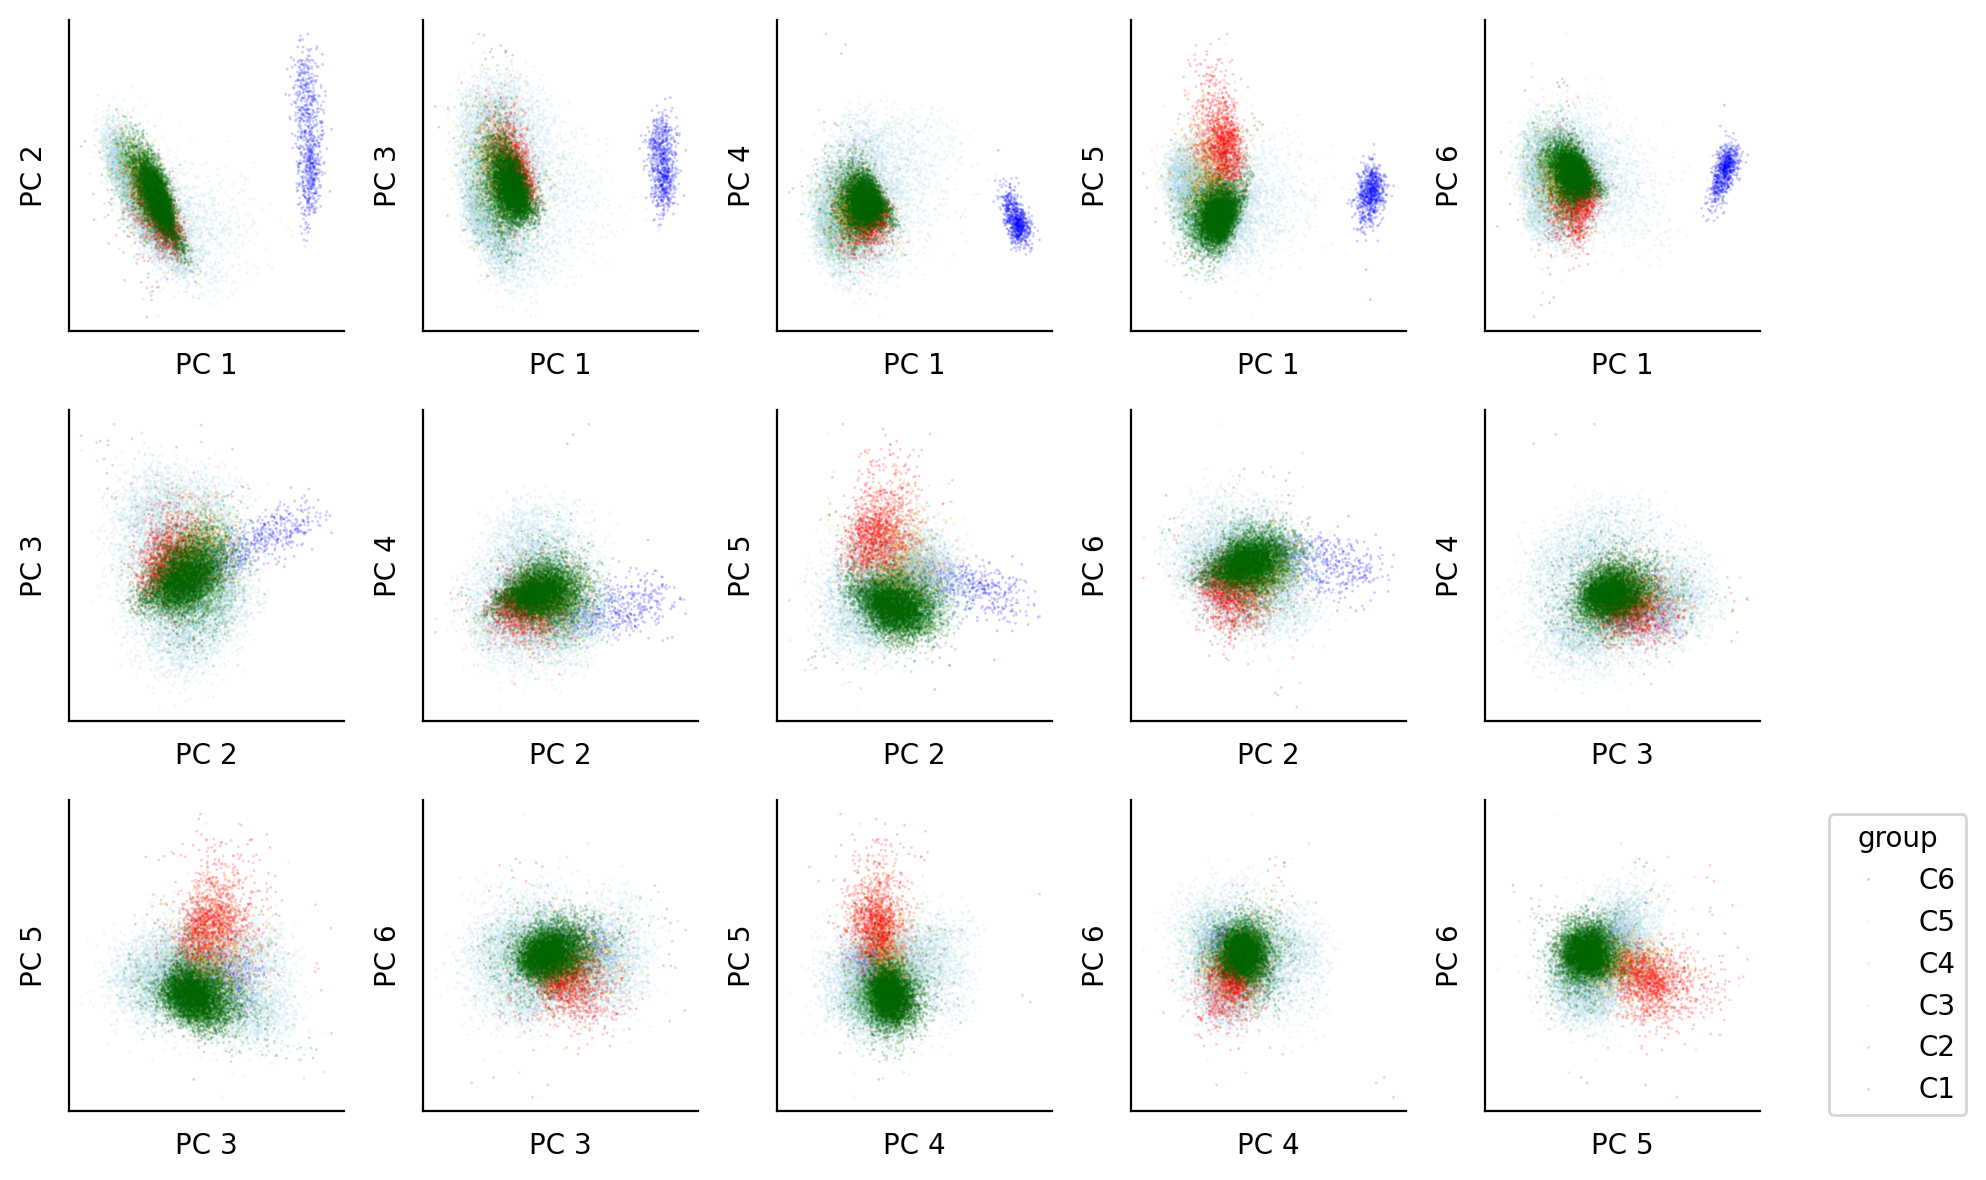

In [15]:
# different PCA coordinate pairs

# conduct PCA
n_comps = 6

pdf = utils.get_stacked_cell_data(adata, genes='marker')
sc.tl.pca(pdf, n_comps=n_comps, 
          use_highly_variable=False)

axis_pairs = list(itertools.combinations(list(range(n_comps)), 2))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 6

colors = [
    'darkgreen',
    'red',
    "orange",
    "limegreen", 
    'lightblue', 
    'blue'
][::-1]

fig, axs = plt.subplots(3, 5)
axs = axs.ravel()

for idx, (i, j) in enumerate(axis_pairs):
    x = pdf.obsm['X_pca'][:, i]
    y = pdf.obsm['X_pca'][:, j]
    c = pdf.obs['group']

    order = np.argsort(pdf.obs['group'].values)[::-1]

    sns.scatterplot(data=pdf.obs.iloc[order], 
                    x=x[order], 
                    y=y[order],
                    hue='group',
                    s=1,
                    alpha=0.2,
                    palette=colors,
                    ec='none',
                    ax=axs[idx])

    axs[idx].set_xticks([])

    if not idx == 14:
        axs[idx].legend().remove()
    else:
        sns.move_legend(axs[idx], loc='upper right',
                       bbox_to_anchor=(1.8, 1))
        
    axs[idx].set_yticks([])
    axs[idx].set_xlabel(f"PC {i+1}")
    axs[idx].set_ylabel(f"PC {j+1}")

plt.tight_layout()
sns.despine()

# distances in PCA space

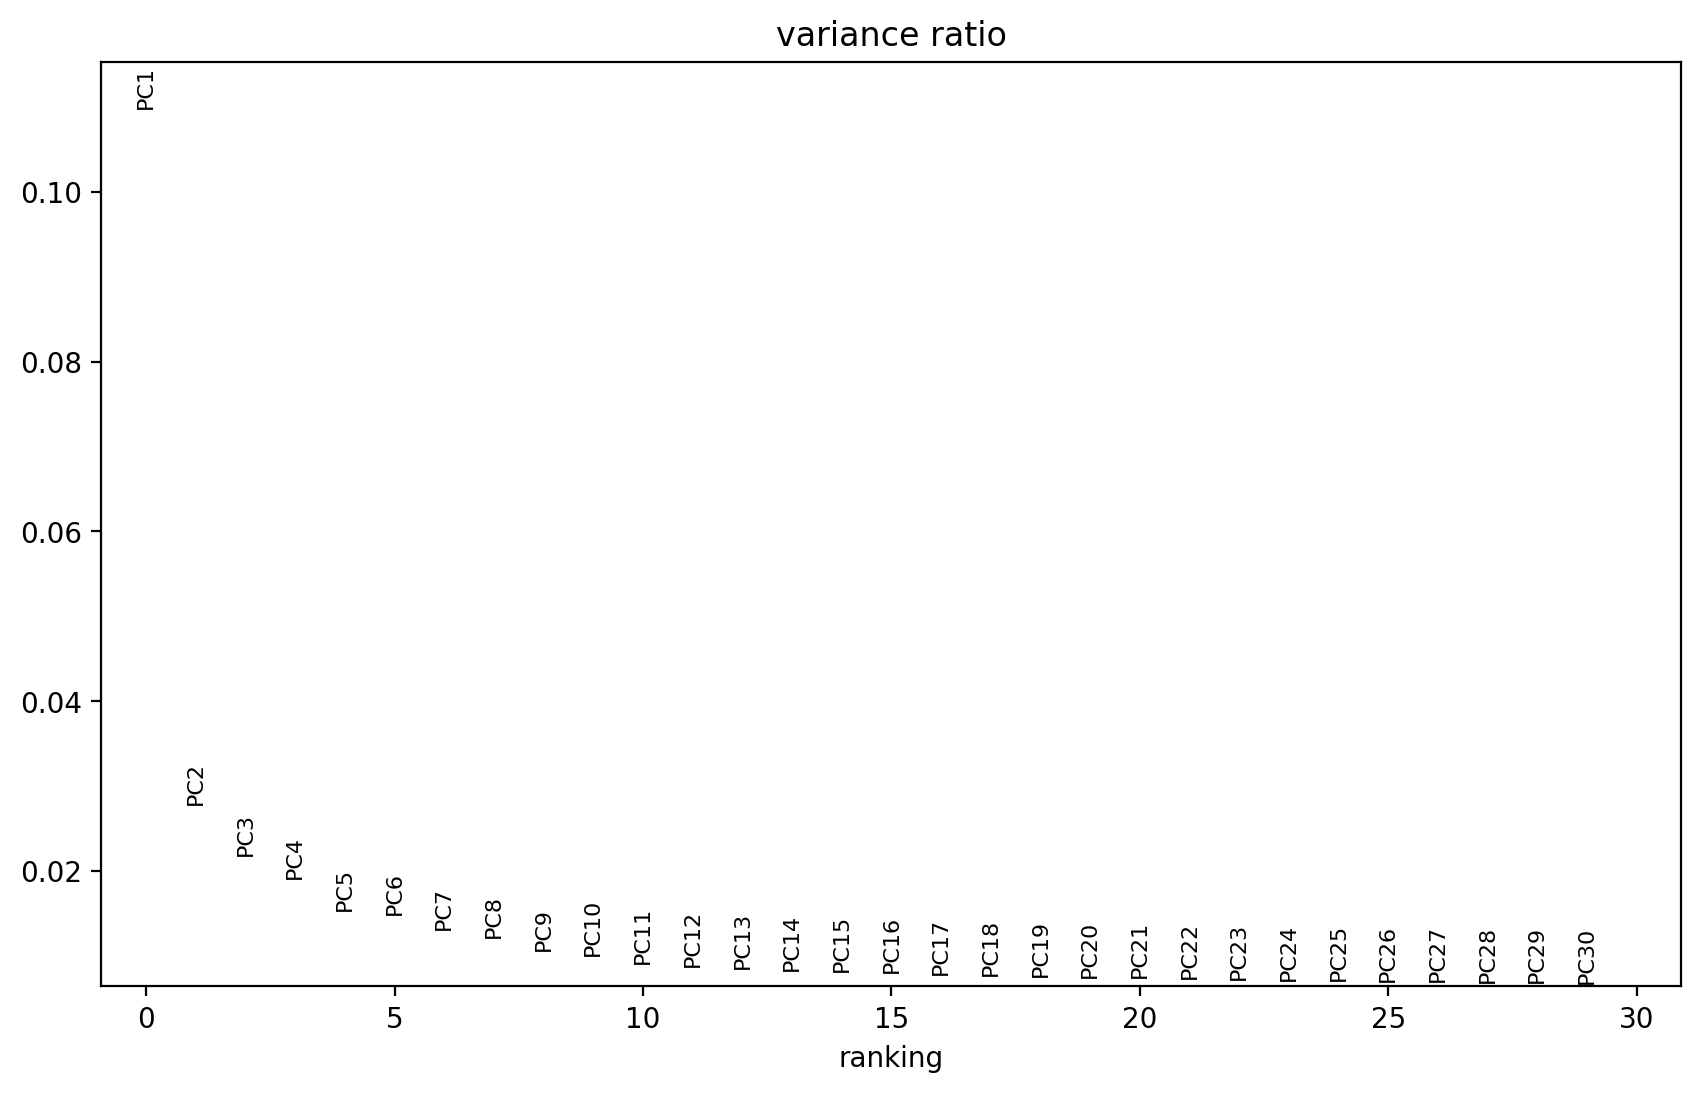

X.shape=(16968, 5)
C1
C2
C3
C4
C5


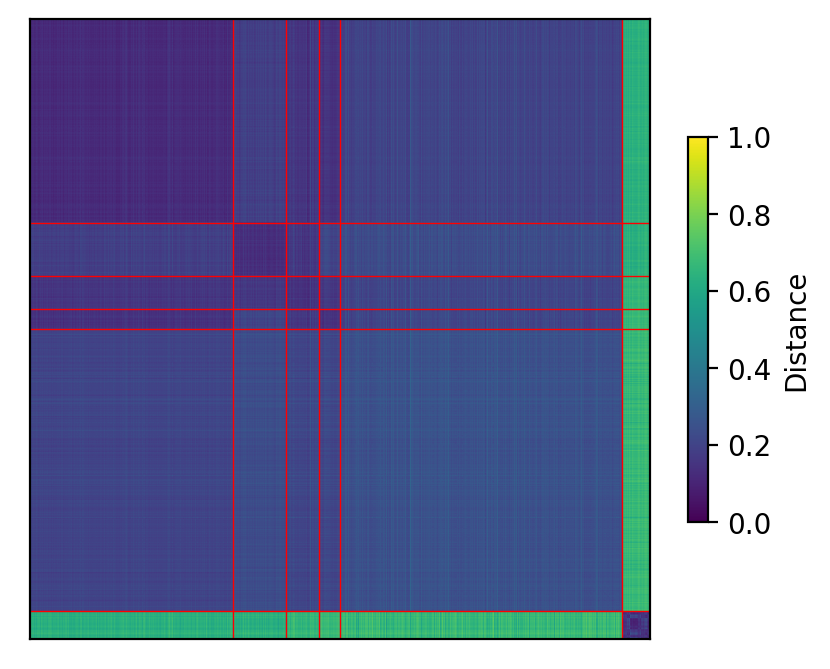

In [16]:
# conduct PCA
metric = 'euclidean'
n_comps = 30
use_n_pca = 5

pdf = utils.get_stacked_cell_data(adata, genes='marker')
sc.tl.pca(pdf, n_comps=n_comps, 
          use_highly_variable=False)

sc.pl.pca_variance_ratio(pdf, n_pcs=n_comps)

X = pdf.obsm['X_pca'][:, 0:use_n_pca]
print(f"{X.shape=}")

# make distance matrix
D = scipy.spatial.distance.pdist(X, metric=metric)
D = min_max(D)
D = scipy.spatial.distance.squareform(D)
D = pd.DataFrame(D, index=pdf.obs.index, 
                 columns=pdf.obs.index)

sorted_idx = pdf.obs.sort_values(by='group').index
group_labels = pdf.obs['group'].sort_values().values
label_switch_idx = np.where(group_labels[:-1] != group_labels[1:])[0]
group_labels_unique = np.unique(group_labels)

D = D[sorted_idx]
D = D.reindex(sorted_idx)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

plt.imshow(D)
plt.colorbar(shrink=0.5, label='Distance')
plt.xticks([], [])
plt.yticks([], [])

for i, idx_val in enumerate(label_switch_idx):
    print(group_labels_unique[i])
    plt.axvline(x=idx_val, c='r', lw=0.5)
    plt.axhline(y=idx_val, c='r', lw=0.5)

Text(0.5, 1.0, 'Mean Distance in PCA Coordinates')

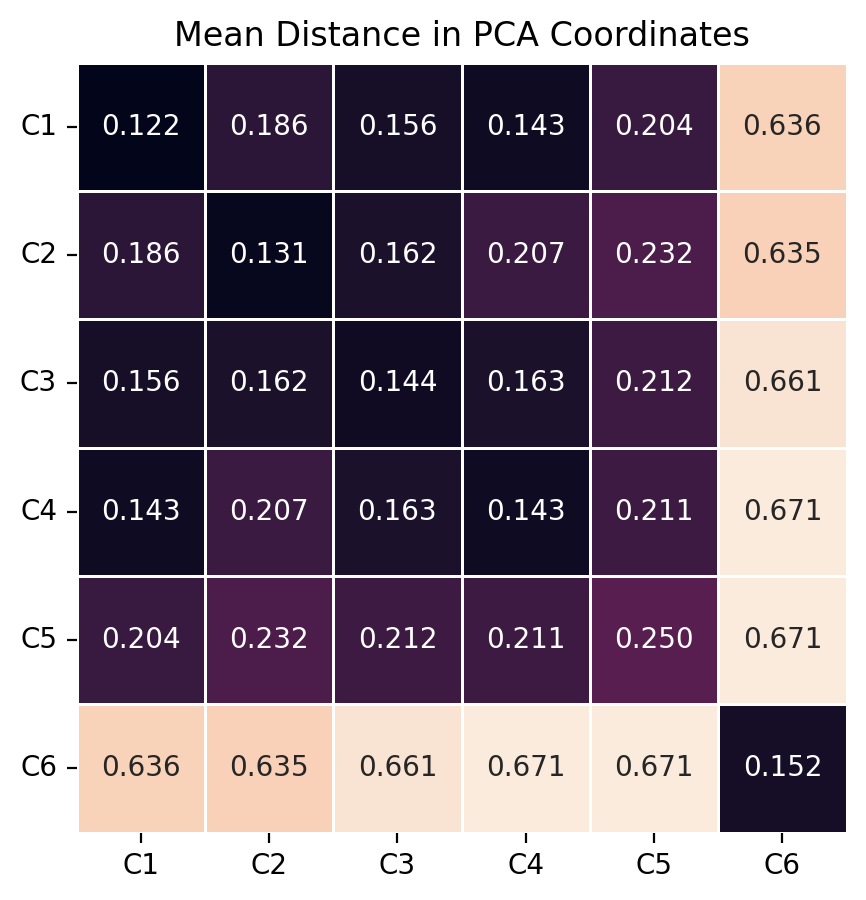

In [17]:
# average distances
res = []

for i_name, group_i in pdf.obs.groupby('group'):
    for j_name, group_j in pdf.obs.groupby('group'):
        i_idx = group_i.index
        j_idx = group_j.index

        mean_dist = np.mean(D.loc[i_idx][j_idx].to_numpy())

        row = {
            'i_name' : i_name,
            'j_name' : j_name,
            'mean_dist' : mean_dist,
        }

        res.append(row)
        
res = pd.DataFrame(res)
res = pd.pivot_table(res, 
                     index='i_name', 
                     columns='j_name', 
                     values='mean_dist')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(res, square=True,
            linewidth=0.5,
            annot=True,
            fmt=".3f",
            cbar=False)

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)
plt.title("Mean Distance in PCA Coordinates")

In [18]:
# break

# Spectral embedding

In [19]:
# metric = 'jensenshannon'
# sample_size = 100

# pdf = utils.get_stacked_cell_data(adata, genes='marker')
# pdf = sc.pp.subsample(pdf, n_obs=sample_size, copy=True)

# X = pdf.X
# print(f"{X.shape=}")

# X = preprocessing.minmax_scale(X, feature_range=(0, 1), axis=1)

# # make distance matrix
# A = scipy.spatial.distance.pdist(X, metric=metric)
# A = min_max(A)
# A = scipy.spatial.distance.squareform(A)
# print(f"{A.shape=}")

# # convert to adjacency 
# t = np.quantile(A, 0.5)
# A = np.where(A > t, 1, 0)

# A = pd.DataFrame(A, index=pdf.obs.index, 
#                  columns=pdf.obs.index)

# Amat = A.to_numpy()
# np.fill_diagonal(Amat, 0)
# L = scipy.sparse.csgraph.laplacian(Amat, normed=True, symmetrized=True)

# # plot the matrices
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 10, 5

# fig, axs = plt.subplots(1, 2)
# sns.heatmap(A, square=True, ax=axs[0], cbar_kws={'shrink' : 0.2})
# sns.heatmap(L, square=True, ax=axs[1], cbar_kws={'shrink' : 0.2})

# axs[0].axis(False)
# axs[1].axis(False)

# plt.show()


# """SVD of L"""
# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 3, 2
# u, s, vh = np.linalg.svd(L)
# plt.plot(s, c='k')
# plt.show()

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 4, 4
# sns.scatterplot(x=u[:, -2], 
#                 y=u[:, -3], 
#                 hue=pdf.obs['group'],
#                 ec='k')

In [20]:
# break

# now UMAP

2024-01-30 08:53:47.369506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 08:53:55.941717: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 08:53:59.979902: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 08:54:30.346649: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

RuntimeError: module compiled against API version 0xf but this version of numpy is 0xe

... storing 'group' as categorical


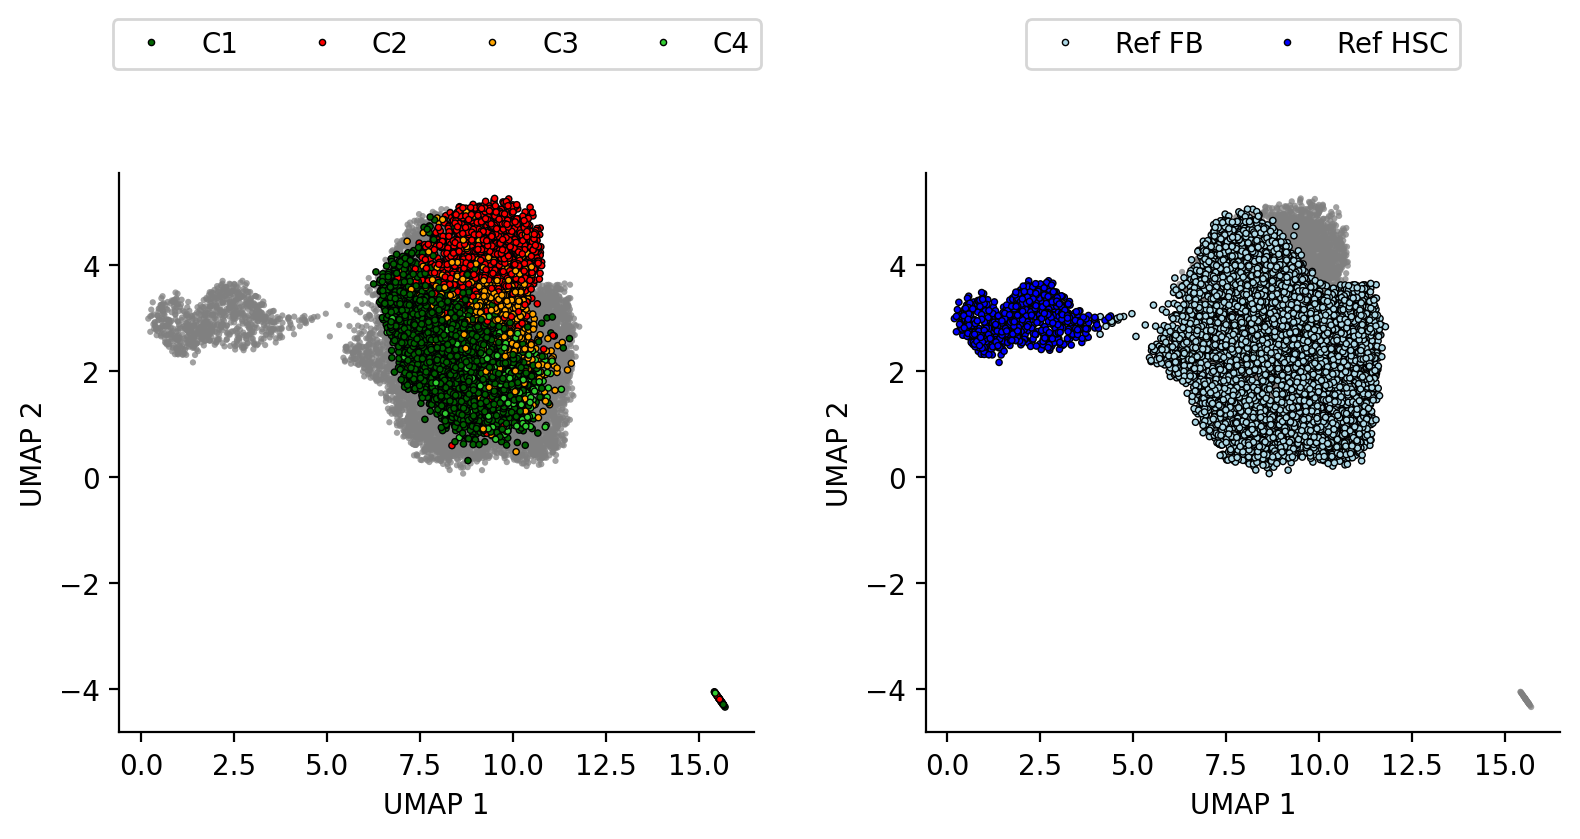

In [21]:
# conduct PCA
knn = 31
n_comps = 10
umap_comps = 10
min_dist = 0.5
spread = 0.26
metric = 'euclidean'

pdf = utils.get_stacked_cell_data(adata, genes='marker')
sc.tl.pca(pdf, n_comps=n_comps, 
          use_highly_variable=False)

sc.pp.neighbors(pdf, 
                n_neighbors=knn, 
                metric=metric, 
                n_pcs=n_comps)

sc.tl.paga(pdf, groups='group')
sc.pl.paga(pdf, plot=False)

sc.tl.umap(pdf, 
           init_pos='paga',
           n_components=umap_comps,
           min_dist=min_dist,
           spread=spread,)

pdf.obs['UMAP 1'] = pdf.obsm['X_umap'][:, 0]
pdf.obs['UMAP 2'] = pdf.obsm['X_umap'][:, 1]

label_map = {
    'C1' : 'C1',
    'C2' : 'C2',
    'C3' : 'C3',
    'C4' : 'C4',
    'C5' : 'Ref FB',
    'C6' : 'Ref HSC',
}

pdf.obs['group_label'] = pdf.obs['group'].map(label_map)
pdf.obs['group_label'] = pdf.obs['group_label'].astype(str)


plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4.5

fig, axs = plt.subplots(1, 2)

palettes = [
    ['darkgreen','red',"orange","limegreen", ],
    ['lightblue','blue'],
]

for i, (data_set, group) in enumerate(pdf.obs.groupby('set')):
    sns.scatterplot(data=pdf.obs,
                    x='UMAP 1',
                    y='UMAP 2',
                    s=5,
                    ec='none',
                    color='grey',
                    zorder=0,
                    alpha=0.75,
                    linewidths=0.5,
                    ax=axs[i])

    sns.scatterplot(data=group,
                    x='UMAP 1',
                    y='UMAP 2',
                    s=5,
                    ec='k',
                    hue='group_label',
                    zorder=1,
                    palette=palettes[i],
                    linewidths=0.5,
                    ax=axs[i])
    
    # structure the legend
    n_groups = group['group_label'].nunique()
    sns.move_legend(axs[i],
                    title="",
                    loc='upper center',
                    ncols=n_groups,
                    bbox_to_anchor=(0.5, 1.3),
                   )
    
sns.despine()
plt.tight_layout()
plt.show()

In [22]:
# # what are these cells?
# layer = "raw_counts"

# over = pdf.obs[pdf.obsm['X_umap'][:, 0] > 20]
# X = pdf[over.index, :]

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 5
# X = X.to_df(layer='raw_counts')
# sns.heatmap(X.T.corr(),
#             square=True,
#             cbar_kws={'shrink' : 0.5},
#             lw=0.5)

# _ = plt.xticks([])
# _ = plt.yticks([])
# plt.show()

# Y = adata[over.index, :].to_df(layer='raw_counts')

# sns.heatmap(Y.T.corr(),
#             square=True,
#             cbar_kws={'shrink' : 0.5},
#             lw=0.5)

# _ = plt.xticks([])
# _ = plt.yticks([])
# plt.show()

In [23]:
# break

In [24]:
# Try some other UMAP coordinate pairs

# conduct PCA
knn = 51
n_comps = 10
umap_comps = 6
metric = 'euclidean'

pdf = utils.get_stacked_cell_data(adata, genes='marker')
sc.tl.pca(pdf, n_comps=n_comps, 
          use_highly_variable=False)

sc.pp.neighbors(pdf, n_neighbors=knn, metric=metric, n_pcs=n_comps)
sc.tl.umap(pdf, n_components=umap_comps)

print('done!')

done!


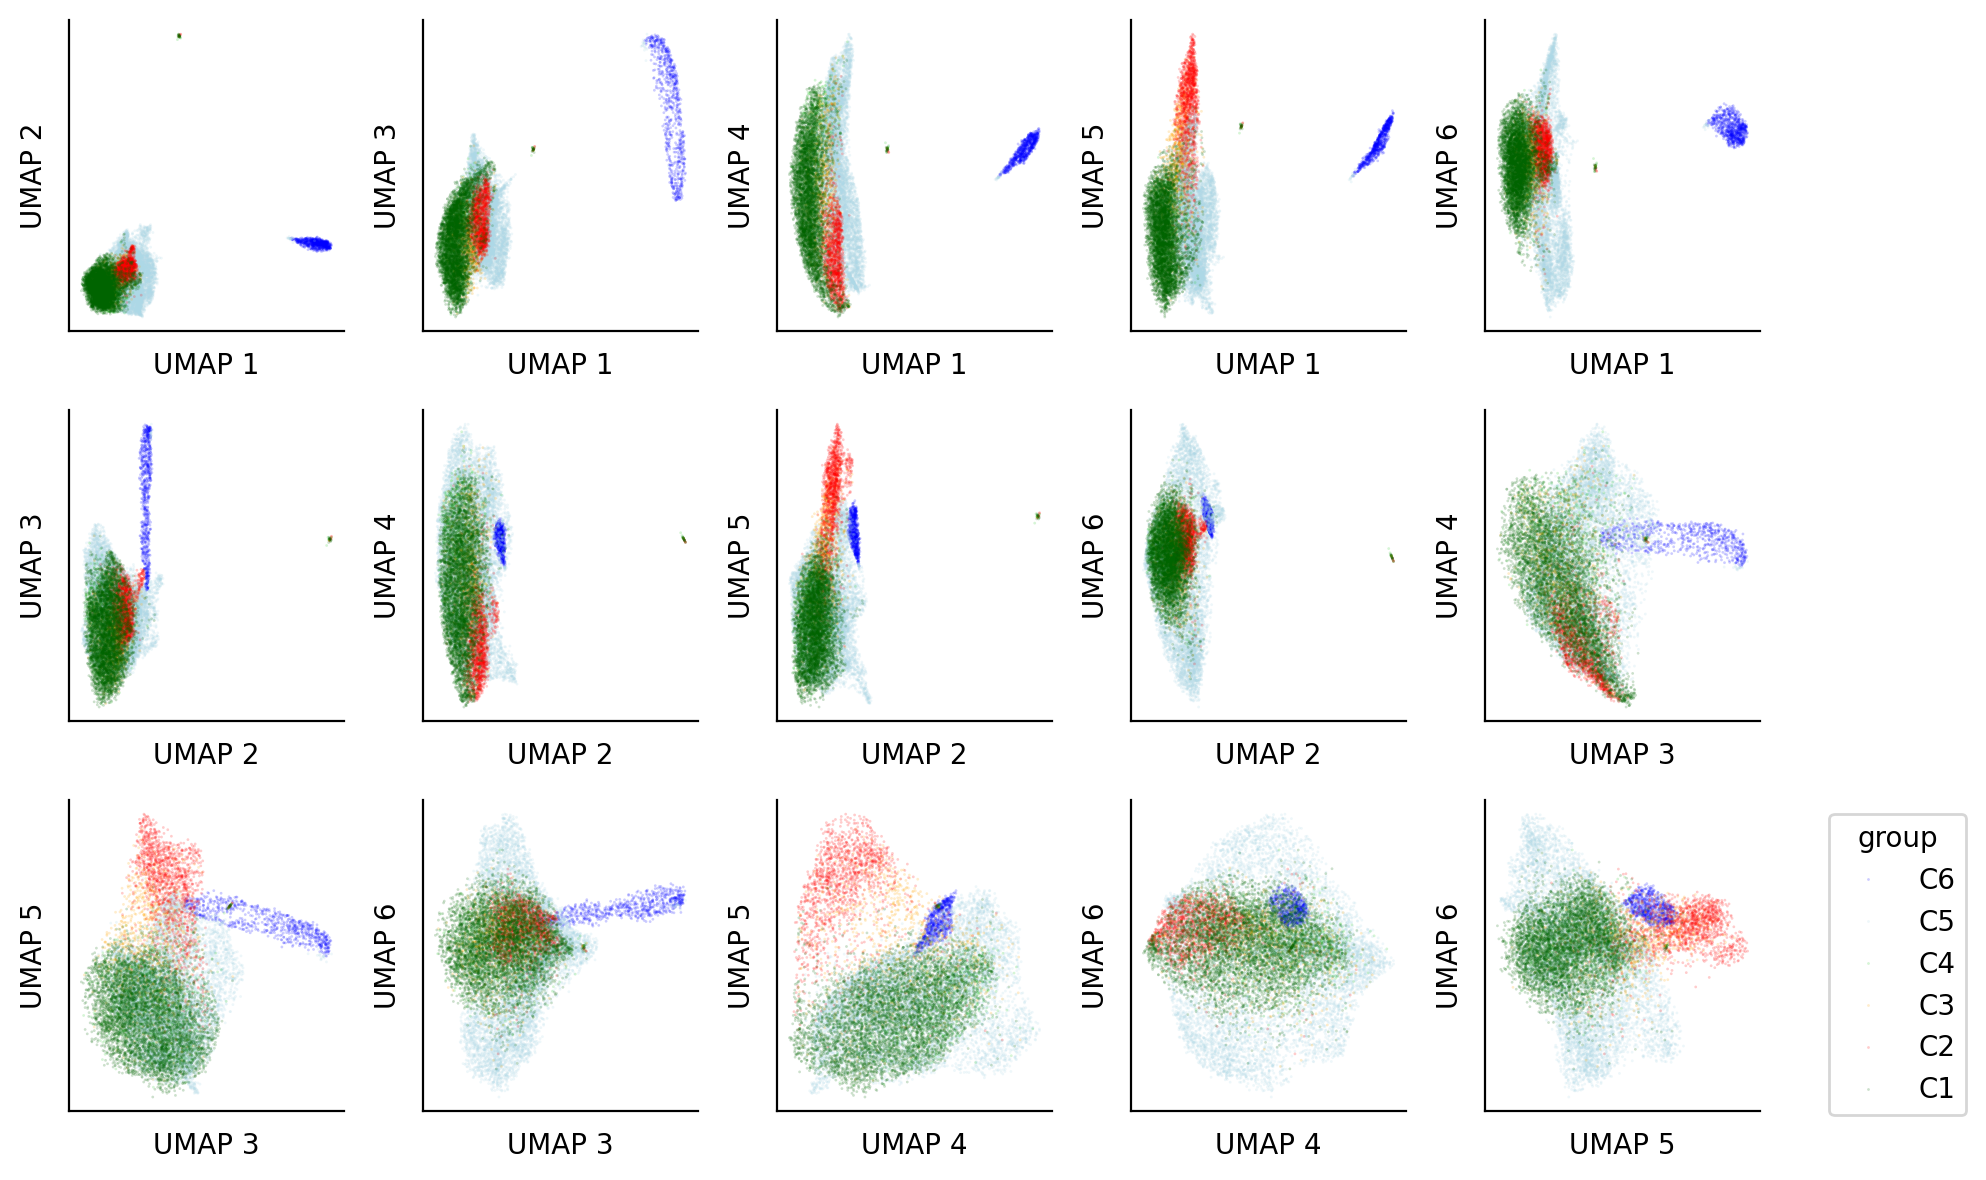

In [25]:
axis_pairs = list(itertools.combinations(list(range(umap_comps)), 2))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 6

colors = [
    'darkgreen',
    'red',
    "orange",
    "limegreen", 
    'lightblue', 
    'blue'
][::-1]

fig, axs = plt.subplots(3, 5)
axs = axs.ravel()

for idx, (i, j) in enumerate(axis_pairs):
    x = pdf.obsm['X_umap'][:, i]
    y = pdf.obsm['X_umap'][:, j]
    c = pdf.obs['group']

    order = np.argsort(pdf.obs['group'].values)[::-1]

    sns.scatterplot(data=pdf.obs.iloc[order], 
                    x=x[order], 
                    y=y[order],
                    hue='group',
                    s=1,
                    alpha=0.2,
                    palette=colors,
                    ec='none',
                    ax=axs[idx])

    axs[idx].set_xticks([])

    if not idx == 14:
        axs[idx].legend().remove()
    else:
        sns.move_legend(axs[idx], loc='upper right',
                       bbox_to_anchor=(1.8, 1))
        
    axs[idx].set_yticks([])
    axs[idx].set_xlabel(f"UMAP {i+1}")
    axs[idx].set_ylabel(f"UMAP {j+1}")

plt.tight_layout()
sns.despine()

In [26]:
# break

# distances in umap space

X.shape=(16968, 10)
C1
C2
C3
C4
C5


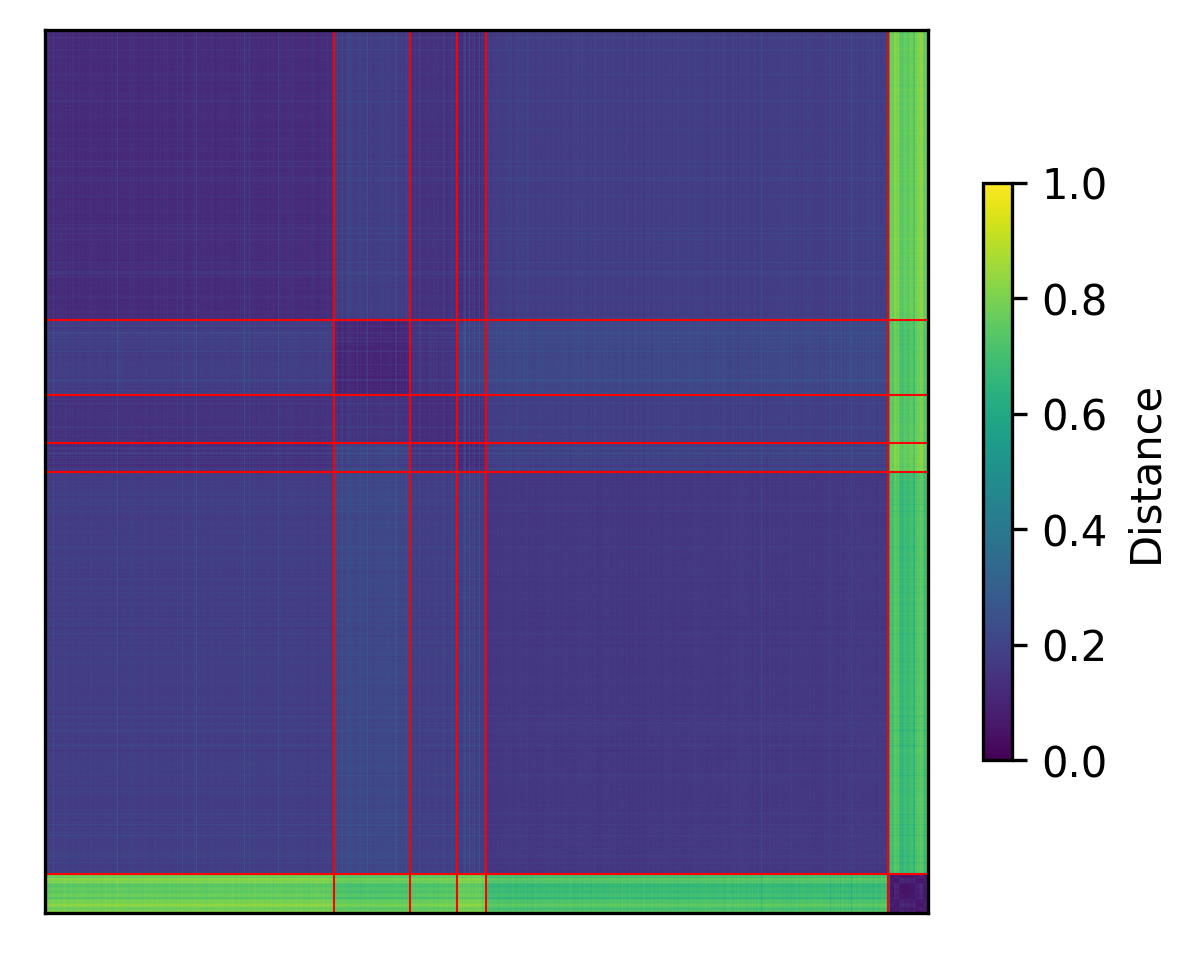

In [45]:
# conduct PCA
metric = 'euclidean'
knn = 51
n_comps = 20
use_n_umap = 10

pdf = utils.get_stacked_cell_data(adata, genes='marker')
sc.tl.pca(pdf, n_comps=n_comps, 
          use_highly_variable=False)

sc.pp.neighbors(pdf, 
                n_neighbors=knn, 
                metric=metric, 
                n_pcs=n_comps)

sc.tl.umap(pdf, n_components = use_n_umap)

X = pdf.obsm['X_umap']
print(f"{X.shape=}")

# make distance matrix
D = scipy.spatial.distance.pdist(X, metric=metric)
D = min_max(D)
D = scipy.spatial.distance.squareform(D)
D = pd.DataFrame(D, index=pdf.obs.index, 
                 columns=pdf.obs.index)

sorted_idx = pdf.obs.sort_values(by='group').index
group_labels = pdf.obs['group'].sort_values().values
label_switch_idx = np.where(group_labels[:-1] != group_labels[1:])[0]
group_labels_unique = np.unique(group_labels)

D = D[sorted_idx]
D = D.reindex(sorted_idx)

plt.imshow(D)
plt.colorbar(shrink=0.5, label='Distance')
plt.xticks([], [])
plt.yticks([], [])

for i, idx_val in enumerate(label_switch_idx):
    print(group_labels_unique[i])
    plt.axvline(x=idx_val, c='r', lw=0.5)
    plt.axhline(y=idx_val, c='r', lw=0.5)

Text(0.5, 1.0, 'Mean Distance in UMAP Coordinates')

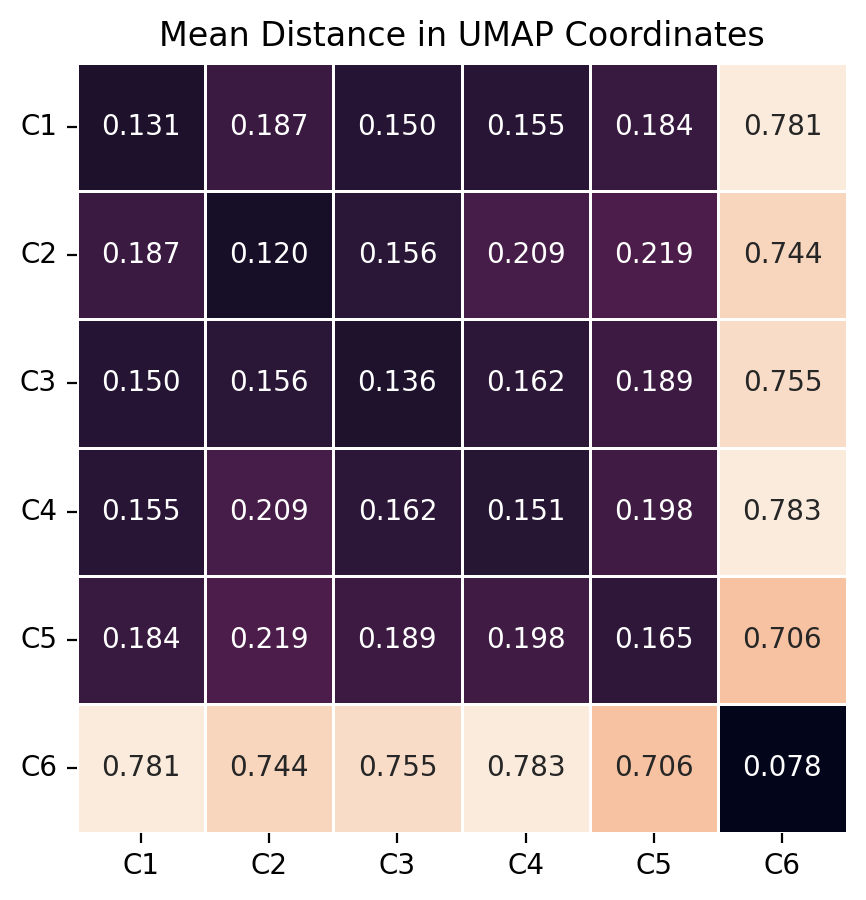

In [46]:
# average distances
res = []

for i_name, group_i in pdf.obs.groupby('group'):
    for j_name, group_j in pdf.obs.groupby('group'):
        i_idx = group_i.index
        j_idx = group_j.index

        mean_dist = np.mean(D.loc[i_idx][j_idx].to_numpy())

        row = {
            'i_name' : i_name,
            'j_name' : j_name,
            'mean_dist' : mean_dist,
        }

        res.append(row)
        
res = pd.DataFrame(res)
res = pd.pivot_table(res, 
                     index='i_name', 
                     columns='j_name', 
                     values='mean_dist')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(res, square=True,
            linewidth=0.5,
            annot=True,
            fmt=".3f",
            cbar=False)

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)
plt.title("Mean Distance in UMAP Coordinates")

In [29]:
# break

# distance to mean signature

[68]


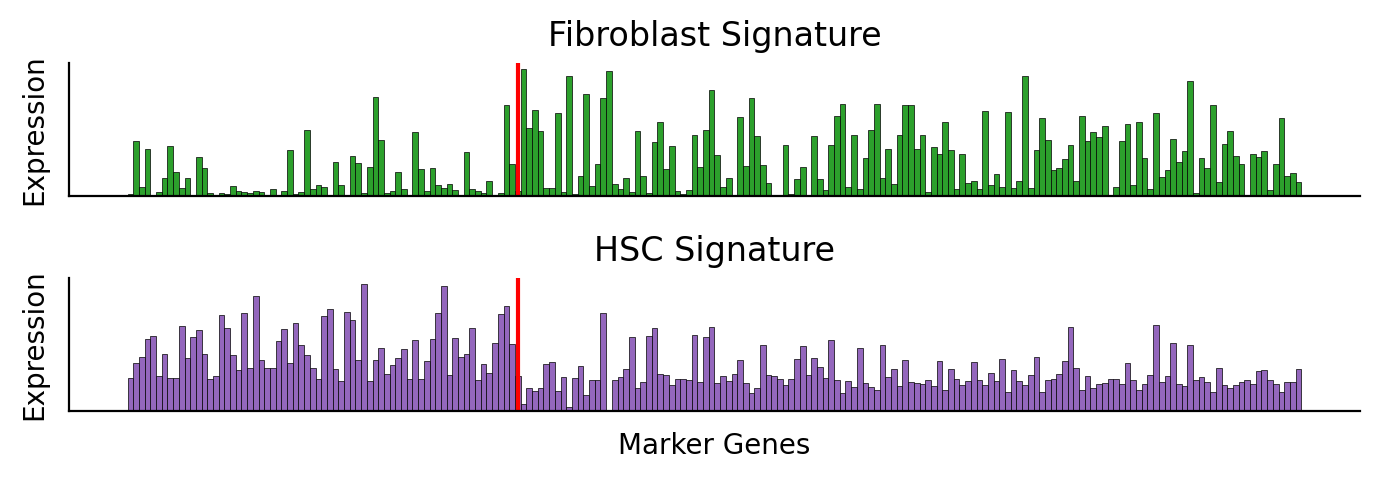

In [30]:
pdf = utils.get_stacked_cell_data(adata, genes='marker')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 2.5

fig, axs = plt.subplots(2, 1)

plt_labels = ['Fibroblast', 'HSC']
colors = ["C2", 'C4']

gene_order = pdf.var.sort_values(by='is_fb_marker').index

labels = pdf.var.sort_values(by='is_fb_marker')['is_fb_marker'].values
label_switch_idx = np.where(labels[:-1] != labels[1:])[0]
print(label_switch_idx)


for i, ref_group in enumerate(["C5", "C6"]):
    signature = pdf[pdf.obs['group'] == ref_group, gene_order].to_df()
    signature = signature.mean(axis=0)
    signature = min_max(signature)

    axs[i].bar(list(range(len(signature))), 
            np.abs(signature),
            width=1,   
            ec='k',
            color=colors[i],
            linewidth=0.25,)

    if not i == 0:
        axs[i].set_xlabel("Marker Genes")
    else:
        axs[i].set_xlabel("")
    axs[i].set_ylabel("Expression")
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(f'{plt_labels[i]} Signature')

    for idx in label_switch_idx:
        axs[i].axvline(x=idx, c='r', )
    
sns.despine()
plt.tight_layout()

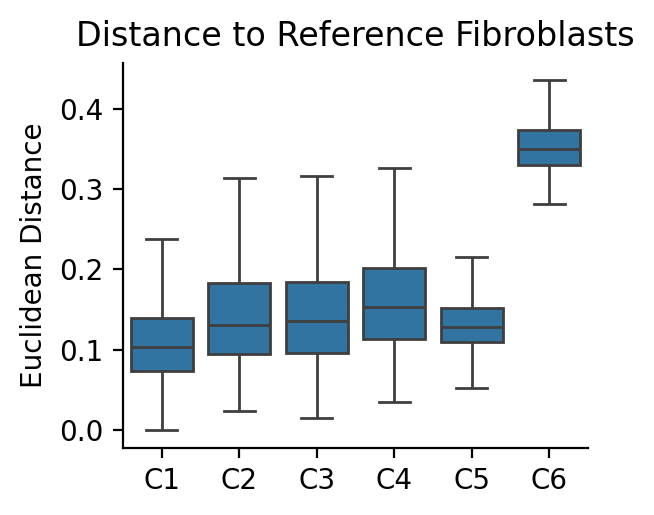

In [31]:
metric = 'euclidean'
ref_group = "C5" 
new_column_name = f'distance_to_{ref_group}'
pdf = utils.get_stacked_cell_data(adata, genes='marker')

signature = pdf[pdf.obs['group'] == ref_group].X.mean(axis=0)
signature = signature.reshape(1, -1)

D = scipy.spatial.distance.cdist(pdf.X, signature, metric=metric)
D = min_max(D)

pdf.obs[new_column_name] = np.ravel(D)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2.5

sns.boxplot(data=pdf.obs,
            x='group',
            y=new_column_name,
            showfliers=False,)

plt.xlabel("")
plt.title('Distance to Reference Fibroblasts')
plt.ylabel(f"{metric.title()} Distance")
sns.despine()

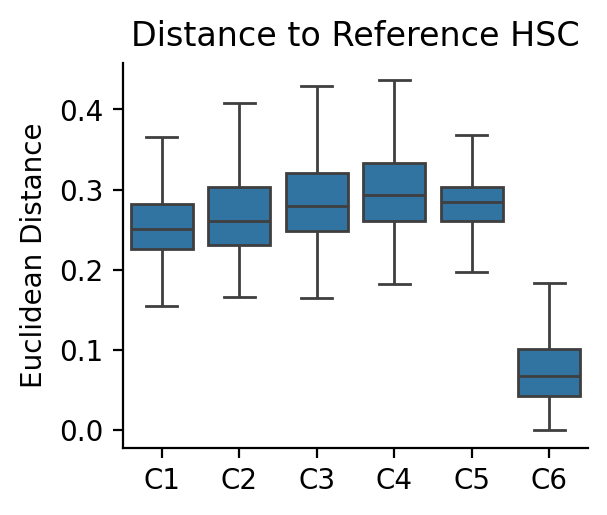

In [32]:
metric = 'euclidean'
ref_group = "C6" 
new_column_name = f'distance_to_{ref_group}'
pdf = utils.get_stacked_cell_data(adata, genes='marker')

signature = pdf[pdf.obs['group'] == ref_group].X.mean(axis=0)
signature = signature.reshape(1, -1)

D = scipy.spatial.distance.cdist(pdf.X, signature, metric=metric)
D = min_max(D)

pdf.obs[new_column_name] = np.ravel(D)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2.5

sns.boxplot(data=pdf.obs,
            x='group',
            y=new_column_name,
            showfliers=False,)

plt.xlabel("")
plt.title('Distance to Reference HSC')
plt.ylabel(f"{metric.title()} Distance")
sns.despine()

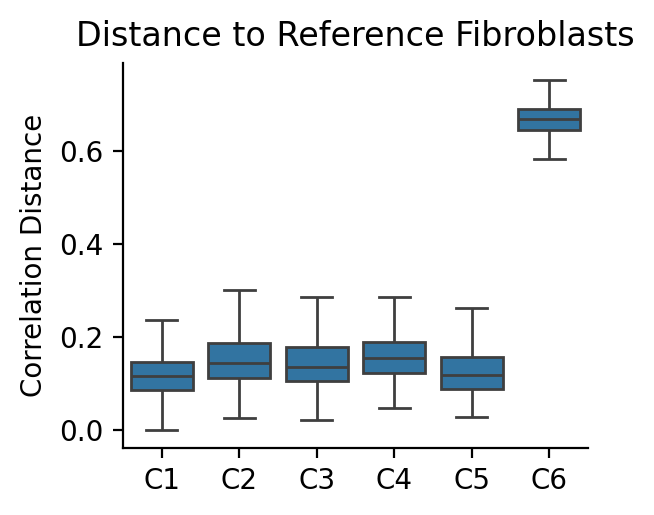

In [33]:
metric = 'correlation'
ref_group = "C5" 
new_column_name = f'distance_to_{ref_group}'
pdf = utils.get_stacked_cell_data(adata, genes='marker')

signature = pdf[pdf.obs['group'] == ref_group].X.mean(axis=0)
signature = signature.reshape(1, -1)

D = scipy.spatial.distance.cdist(pdf.X, signature, metric=metric)
D = min_max(D)

pdf.obs[new_column_name] = np.ravel(D)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 2.5

sns.boxplot(data=pdf.obs,
            x='group',
            y=new_column_name,
            showfliers=False,)

plt.xlabel("")
plt.title('Distance to Reference Fibroblasts')
plt.ylabel(f"{metric.title()} Distance")
sns.despine()

# Statistical test

In [34]:
metric = 'euclidean'
ref_group = "C5" 
new_column_name = f'distance_to_{ref_group}'
pdf = utils.get_stacked_cell_data(adata, genes='marker')

signature = pdf[pdf.obs['group'] == ref_group].X.mean(axis=0)
signature = signature.reshape(1, -1)

D = scipy.spatial.distance.cdist(pdf.X, signature, metric=metric)
D = min_max(D)

pdf.obs[new_column_name] = np.ravel(D)

"""copy the data """
pdx = pdf.obs.copy()

# drop the reference data
pdx = pdx[pdx['set'] == 'our_data']

res = []

for cluster in pdx['cluster_name'].unique():

    mask = (pdx['cluster_name'] == cluster)
    in_group = pdx[mask]
    out_group = pdx[~mask]

    score, pval = scipy.stats.ttest_ind(in_group[new_column_name],
                                        out_group[new_column_name],
                                        equal_var=False,
                                        alternative='less')

    row = {
        'cluster' : cluster,
        'score' : score,
        'pval' : pval,
        'in_group_mean' : in_group[new_column_name].mean(),
        'out_group_mean' : out_group[new_column_name].mean(),
    }

    res.append(row)

res =  pd.DataFrame(res)
res.head()

cluster      score          pval  in_group_mean  out_group_mean
0      C1 -19.114119  4.286745e-79       0.117564        0.154436
1      C2   9.790695  1.000000e+00       0.150610        0.126057
2      C3   7.372569  1.000000e+00       0.149617        0.127921
3      C4  11.165948  1.000000e+00       0.172209        0.127291

In [35]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# get closest cells to signature

[68]


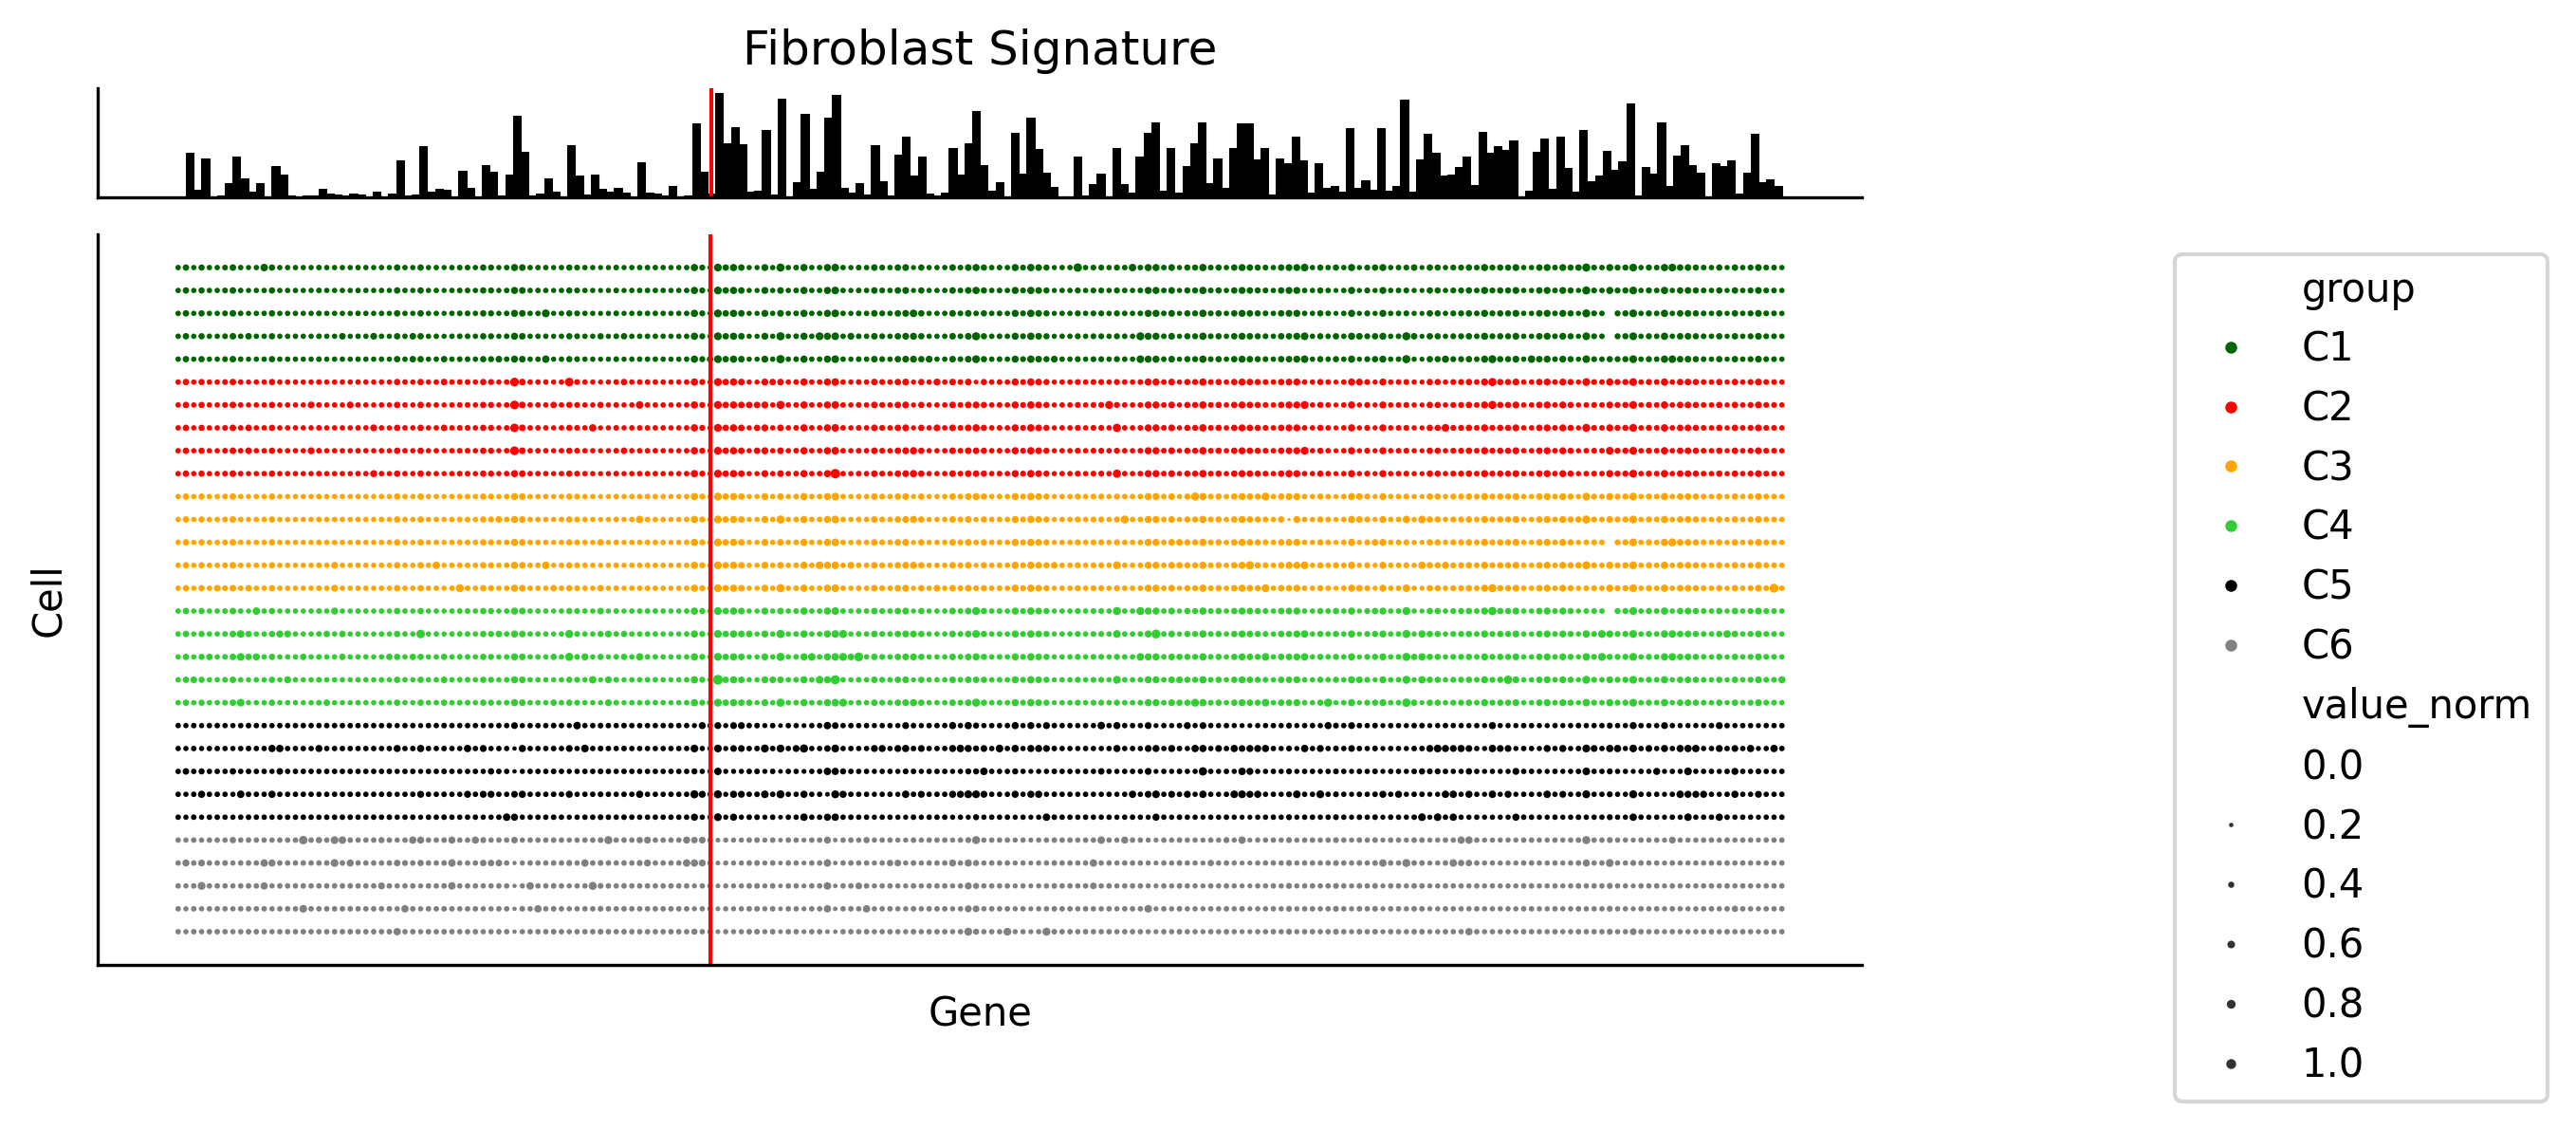

In [36]:
metric = 'euclidean'
top_n_cells = 5
ref_group = "C5" 
new_column_name = f'distance_to_{ref_group}'
pdf = utils.get_stacked_cell_data(adata, genes='marker')

gene_order = pdf.var.sort_values(by='is_fb_marker').index

labels = pdf.var.sort_values(by='is_fb_marker')['is_fb_marker'].values
label_switch_idx = np.where(labels[:-1] != labels[1:])[0]
print(label_switch_idx)

signature = pdf[pdf.obs['group'] == ref_group, gene_order].to_df()
signature = signature.mean(axis=0)
signature = signature.to_numpy().reshape(1, -1)

D = scipy.spatial.distance.cdist(pdf.X, signature, metric=metric)
D = min_max(D)

pdf.obs[new_column_name] = np.ravel(D)

"""Copy the data """
pdx = pdf.obs.copy()
pdx = pdx.sort_values(by=['group', new_column_name],
                      ascending=[True, True])

idx = pdx.groupby('group').head(top_n_cells).index
cells = pdf[idx, gene_order].to_df()
cells = cells.reset_index(drop=False)
cells = cells.rename(columns={'index' : 'cell_index'})
cells = cells.reset_index(drop=False)
cells = pd.melt(cells, id_vars=['index', 'cell_index'])
cells['value_norm'] = min_max(cells['value'].to_numpy())
cells['value_norm_log'] = np.log1p(cells['value_norm'].to_numpy())

cells = pd.merge(cells, pdx,
                 how='left',
                 left_on='cell_index',
                 right_index=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4

colors = [
    'darkgreen',
    'red',
    "orange",
    "limegreen", 
    'k', 
    'grey'
]

sns.scatterplot(data=cells,
                x='gene_name',
                y='index',
                marker=".",
                hue='group',
                ec='none',
                palette=colors,
                size='value_norm',
                sizes=(0, 25),
               )

_ = plt.yticks([])
_ = plt.xticks([], [])
plt.ylabel('Cell')
plt.xlabel('Gene')
plt.axvline(x=label_switch_idx[0], lw=1, c='r')
plt.gca().invert_yaxis()
ax = plt.gca()

sns.move_legend(ax, 
                loc='upper right',
                bbox_to_anchor=(1.4, 1))

ax_divider = make_axes_locatable(ax)
ax2 = ax_divider.append_axes("top", size="15%", pad="5%")

ax2.bar(list(range(len(np.ravel(signature)))), 
        np.abs(np.ravel(signature)),
        width=1,   
        ec='k',
        color="k",
        linewidth=0.25,)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Fibroblast Signature")
ax2.axvline(x=label_switch_idx[0], lw=1, c='r')

# plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'w'

sns.despine()

[68]


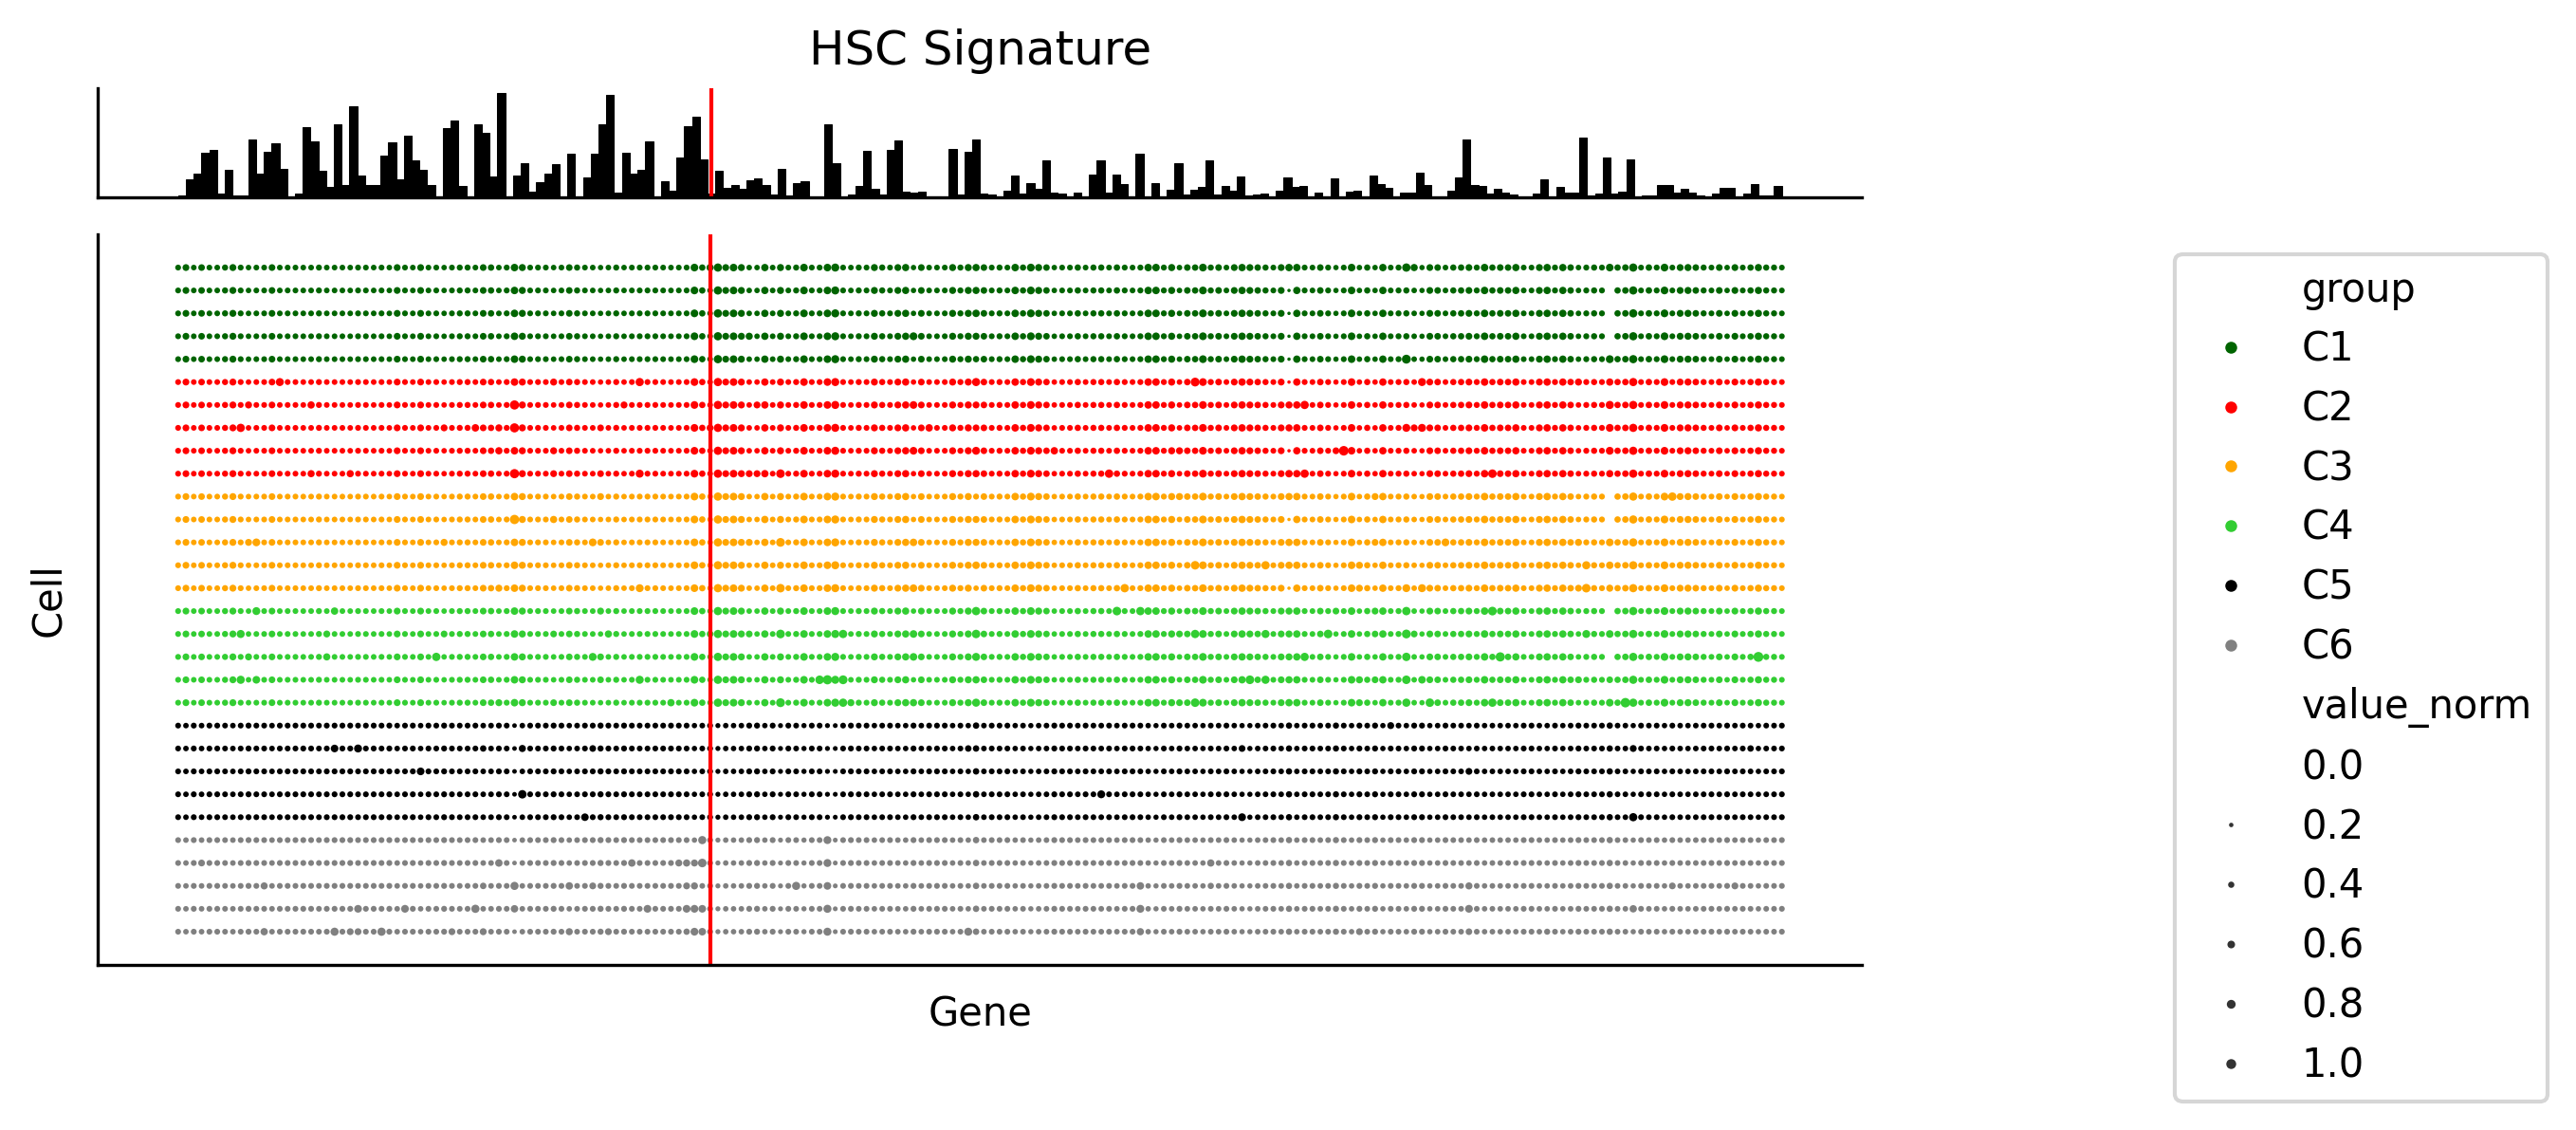

In [37]:
metric = 'euclidean'
top_n_cells = 5
ref_group = "C6" 
new_column_name = f'distance_to_{ref_group}'
pdf = utils.get_stacked_cell_data(adata, genes='marker')

gene_order = pdf.var.sort_values(by='is_fb_marker').index

labels = pdf.var.sort_values(by='is_fb_marker')['is_fb_marker'].values
label_switch_idx = np.where(labels[:-1] != labels[1:])[0]
print(label_switch_idx)

signature = pdf[pdf.obs['group'] == ref_group, gene_order].to_df()
signature = signature.mean(axis=0)
signature = signature.to_numpy().reshape(1, -1)

D = scipy.spatial.distance.cdist(pdf.X, signature, metric=metric)
D = min_max(D)

pdf.obs[new_column_name] = np.ravel(D)

"""Copy the data """
pdx = pdf.obs.copy()
pdx = pdx.sort_values(by=['group', new_column_name],
                      ascending=[True, True])

idx = pdx.groupby('group').head(top_n_cells).index
cells = pdf[idx, gene_order].to_df()
cells = cells.reset_index(drop=False)
cells = cells.rename(columns={'index' : 'cell_index'})
cells = cells.reset_index(drop=False)
cells = pd.melt(cells, id_vars=['index', 'cell_index'])
cells['value_norm'] = min_max(cells['value'].to_numpy())
cells['value_norm_log'] = np.log1p(cells['value_norm'].to_numpy())

cells = pd.merge(cells, pdx,
                 how='left',
                 left_on='cell_index',
                 right_index=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4

colors = [
    'darkgreen',
    'red',
    "orange",
    "limegreen", 
    'k', 
    'grey'
]

sns.scatterplot(data=cells,
                x='gene_name',
                y='index',
                marker=".",
                hue='group',
                ec='none',
                palette=colors,
                size='value_norm',
                sizes=(0, 25),
               )

_ = plt.yticks([])
_ = plt.xticks([], [])
plt.ylabel('Cell')
plt.xlabel('Gene')
plt.axvline(x=label_switch_idx[0], lw=1, c='r')
plt.gca().invert_yaxis()
ax = plt.gca()

sns.move_legend(ax, 
                loc='upper right',
                bbox_to_anchor=(1.4, 1))

ax_divider = make_axes_locatable(ax)
ax2 = ax_divider.append_axes("top", size="15%", pad="5%")

ax2.bar(list(range(len(np.ravel(signature)))), 
        np.abs(np.ravel(signature)),
        width=1,   
        ec='k',
        color="k",
        linewidth=0.25,)

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("HSC Signature")
ax2.axvline(x=label_switch_idx[0], lw=1, c='r')

# plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'w'

sns.despine()

# Different distance metrics

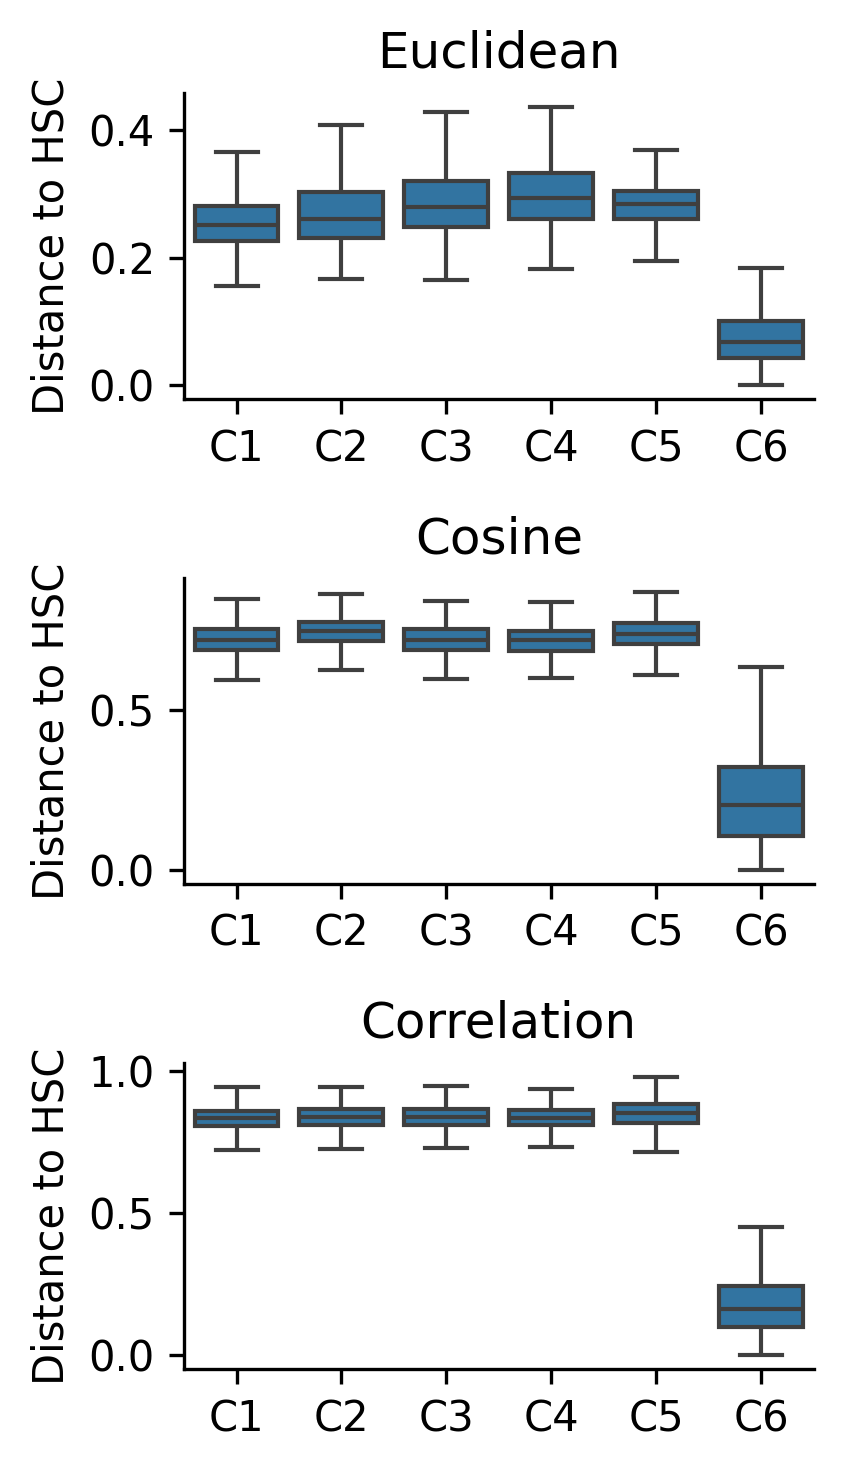

In [38]:
ref_group = "C6" 
pdf = utils.get_stacked_cell_data(adata, genes='marker')

signature = pdf[pdf.obs['group'] == ref_group].X.mean(axis=0)
signature = signature.reshape(1, -1)

metrics = [
    'euclidean',
    'cosine',
    'correlation',
]

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 5
fig, axs = plt.subplots(len(metrics), 1)


for i, metric in enumerate(metrics):
    D = scipy.spatial.distance.cdist(pdf.X, signature, metric=metric)
    D = min_max(D)

    pdf.obs[f'{metric}'] = np.ravel(D)
    sns.boxplot(data=pdf.obs, 
                x='group',
                y=metric,
                ax=axs[i],
                showfliers=False)
    
    axs[i].set_title(metric.title())
    axs[i].set_ylabel("Distance to HSC")
    axs[i].set_xlabel("")


plt.tight_layout()
sns.despine()

# jensen shannon divergence

X.shape=(16968, 206)


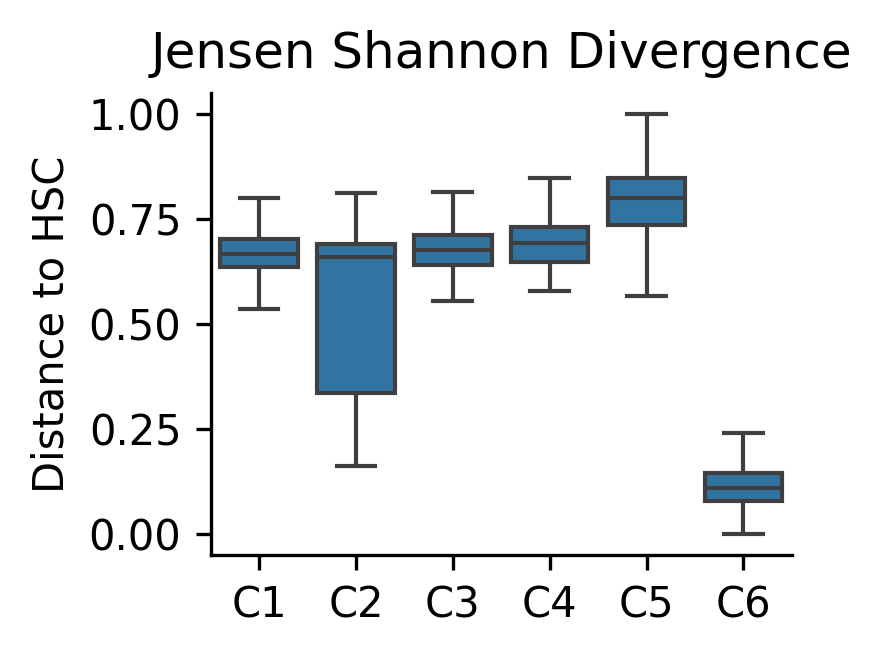

In [39]:
ref_group = "C6" 
pdf = utils.get_stacked_cell_data(adata, genes='marker')

signature = pdf[pdf.obs['group'] == ref_group].X.mean(axis=0)
signature = min_max(signature)
signature = signature.reshape(1, -1)

X = pdf.X
print(f"{X.shape=}")

Xhat = preprocessing.minmax_scale(X, feature_range=(0, 1), axis=1)

D = scipy.spatial.distance.cdist(Xhat, signature, metric='jensenshannon')
D = min_max(D)

pdf.obs['Distance'] = np.ravel(D)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2.5, 2
sns.boxplot(data=pdf.obs, 
            x='group',
            y='Distance',
            showfliers=False)
plt.xlabel("")
plt.ylabel("Distance to HSC")
plt.title("Jensen Shannon Divergence")
sns.despine()

X.shape=(16968, 206)


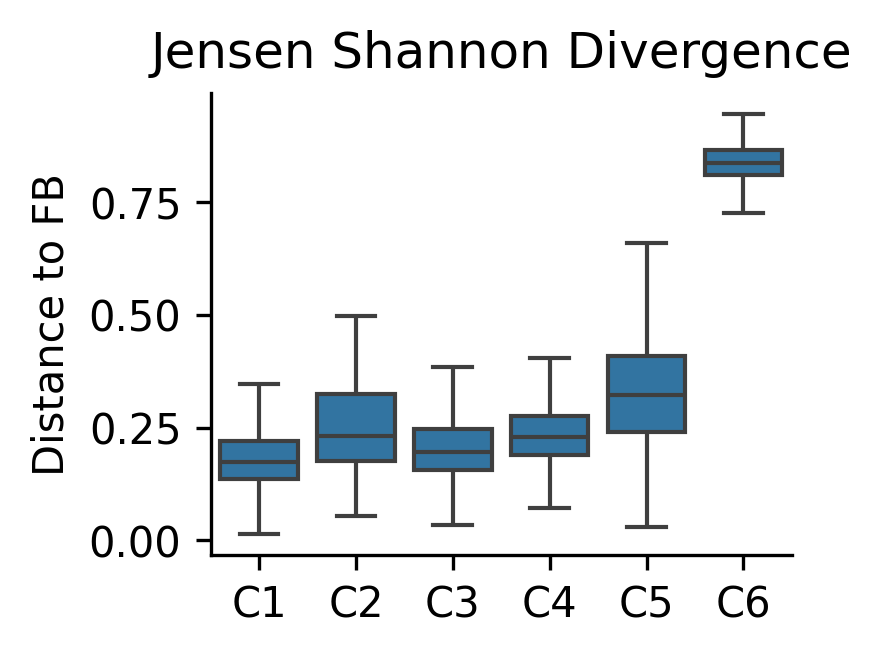

In [40]:
ref_group = "C5" 
pdf = utils.get_stacked_cell_data(adata, genes='marker')

signature = pdf[pdf.obs['group'] == ref_group].X.mean(axis=0)
signature = min_max(signature)
signature = signature.reshape(1, -1)

X = pdf.X
print(f"{X.shape=}")

Xhat = preprocessing.minmax_scale(X, feature_range=(0, 1), axis=1)

D = scipy.spatial.distance.cdist(Xhat, signature, metric='jensenshannon')
D = min_max(D)

pdf.obs['Distance'] = np.ravel(D)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2.5, 2
sns.boxplot(data=pdf.obs, 
            x='group',
            y='Distance',
            showfliers=False)
plt.xlabel("")
plt.ylabel("Distance to FB")
plt.title("Jensen Shannon Divergence")
sns.despine()

# minimum distance to HSC (JSD)

C6: X.shape=(8484, 206) Y.shape=(760, 206)
D.shape=(8484, 760)
AnnData object with n_obs × n_vars = 8484 × 206
    obs: 'cluster_name', 'set', 'UMAP 1', 'UMAP 2', 'organ_tissue', 'celltype', 'group', 'mean_C6', 'min_C6', 'max_C6', 'std_C6'
    var: 'gene_id', 'gene_symbol', 'is_fb_marker', 'is_hsc_marker'
    uns: 'log1p'
    layers: 'combat_corrected', 'log_tpm', 'raw_counts'


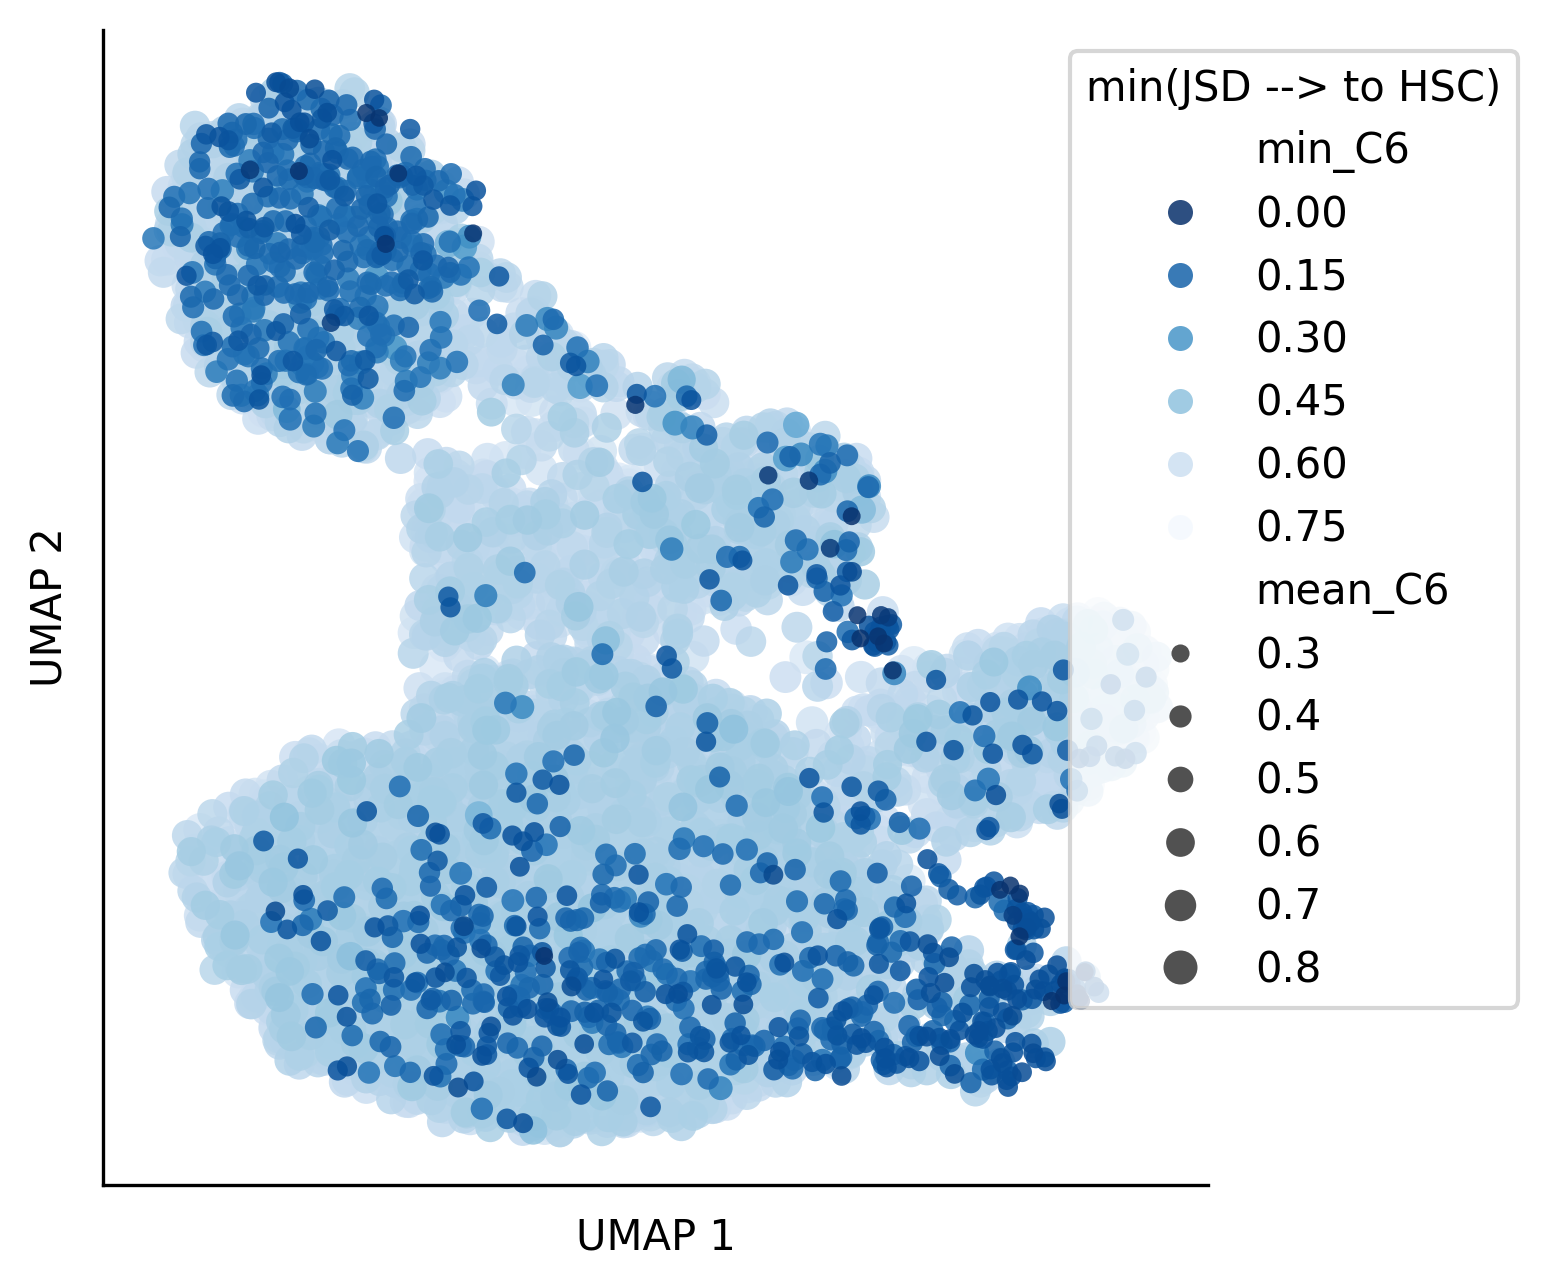

In [43]:
def quick_scale(x):
    return preprocessing.minmax_scale(x, feature_range=(0, 1), axis=1)

ref_groups = ["C6", "C5"]
# sample_size = 5000

# get our data
pdf = utils.get_stacked_cell_data(adata, genes='marker')
# pdf = sc.pp.subsample(pdf, n_obs=sample_size, copy=True)

#subset our data
res = pdf[~pdf.obs['group'].isin(ref_groups)]
X = res.X
X = quick_scale(X)

for target in ref_groups:

    # subset the target data
    Y = pdf[pdf.obs['group'] == target].X
    Y = quick_scale(Y)
    print(f"{target}: {X.shape=} {Y.shape=}")

    # get distance
    D = scipy.spatial.distance.cdist(X, Y, metric='jensenshannon')
    D = min_max(D)
    print(f"{D.shape=}")

    res.obs[f'mean_{target}'] = D.mean(axis=1)
    res.obs[f'min_{target}'] = D.min(axis=1)
    res.obs[f'max_{target}'] = D.max(axis=1)
    res.obs[f'std_{target}'] = D.std(axis=1)

    break

print(res)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.75, 5

order = np.argsort(res.obs['min_C6'])[::-1]

sns.scatterplot(data=res.obs.iloc[order],
                x='UMAP 1',
                y='UMAP 2',
                hue='min_C6',
                palette='Blues_r',
                ec='None',
                alpha=0.85,
                zorder=5,
                size='mean_C6')

plt.yticks([])
plt.xticks([])
plt.ylabel("UMAP 2")
plt.xlabel("UMAP 1")
sns.despine()

sns.move_legend(plt.gca(),
                loc='upper right',
                bbox_to_anchor=(1.3, 1),
                title="min(JSD --> to HSC)")

In [ ]:
break

# JSD By cell

In [ ]:
def scale(x):
    return preprocessing.minmax_scale(x, feature_range=(0, 1), axis=1)

In [ ]:
ref_groups = ["C6", "C5"]
sample_size = 5000

# get our data
pdf = utils.get_stacked_cell_data(adata, genes='marker')
pdf = sc.pp.subsample(pdf, n_obs=sample_size, copy=True)
res = pdf[~pdf.obs['group'].isin(ref_groups)]
X = res.X
print(f"{X.shape=}")
X = scale(X)


for target in ref_groups:
    Y = pdf[pdf.obs['group'] == target].X
    Y = scale(Y)
    print(f"{target}: {Y.shape=}")

    # get distance
    D = scipy.spatial.distance.cdist(X, Y, metric='jensenshannon')
    D = scale(D)
    print(f"{D.shape=}")

    res.obs[f'mean_{target}'] = D.mean(axis=1)
    res.obs[f'std_{target}'] = D.std(axis=1)

    break

res

In [ ]:
sns.scatterplot(data=res.obs,
                x='UMAP 1',
                y='UMAP 2',
                hue='mean_C6',
                palette='Blues_r',
                ec='k',
                alpha=0.7,
                zorder=5,
                s=3)

sns.histplot(data=res.obs, 
             x='UMAP 1',
             y='UMAP 2',
             zorder=2,
             alpha=0.25,
            )

sns.move_legend(plt.gca(),
                loc='upper right',
                bbox_to_anchor=(1.6, 1))

sns.despine()

In [ ]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

field = "distance2_fb"
pdx = pdf.obs.copy()
order = np.argsort(pdx[field].to_numpy())[::-1]

sns.scatterplot(data=pdx.iloc[order], 
                x='UMAP 1',
                y='UMAP 2',
                s=5,
                alpha=0.6,
                palette='plasma',
                hue=field,
                ec='none')

sns.move_legend(plt.gca(),
                loc='upper right',
                bbox_to_anchor=(1.6, 1))

In [ ]:
break

# TF-IDF representation

In [ ]:
pdf

In [ ]:
metric = 'cosine'
pdf = utils.get_stacked_cell_data(adata, genes='marker')
X = pdf.layers['batch_corrected'].copy()
# X = pdf.X

# min max scaling
X = preprocessing.minmax_scale(X, feature_range=(0, 1), axis=1)
X = pd.DataFrame(X, index=pdf.obs.index, 
                 columns=pdf.var_names)

# tf-idf transform
tfidf = TfidfTransformer()
Xhat = tfidf.fit_transform(X).todense()
Xhat = pd.DataFrame(Xhat, index=pdf.obs.index, 
                    columns=pdf.var_names)


D = scipy.spatial.distance.pdist(Xhat, metric=metric)
D = scipy.spatial.distance.squareform(D)
D = pd.DataFrame(D, index=pdf.obs.index, 
                 columns=pdf.obs.index)

sorted_idx = pdf.obs.sort_values(by='group').index
group_labels = pdf.obs['group'].sort_values().values
label_switch_idx = np.where(group_labels[:-1] != group_labels[1:])[0]
group_labels_unique = np.unique(group_labels)

D = D[sorted_idx]
D = D.reindex(sorted_idx)

plt.imshow(D)
plt.xticks([], [])
plt.yticks([], [])

for i, idx_val in enumerate(label_switch_idx):
    print(group_labels_unique[i])
    plt.axvline(x=idx_val, c='r', lw=0.5)
    plt.axhline(y=idx_val, c='r', lw=0.5)

In [ ]:
# average distances
res = []

for i_name, group_i in pdf.obs.groupby('group'):
    for j_name, group_j in pdf.obs.groupby('group'):
        i_idx = group_i.index
        j_idx = group_j.index

        mean_dist = np.mean(D.loc[i_idx][j_idx].to_numpy())

        row = {
            'i_name' : i_name,
            'j_name' : j_name,
            'mean_dist' : mean_dist,
        }

        res.append(row)
        
res = pd.DataFrame(res)
res = pd.pivot_table(res, 
                     index='i_name', 
                     columns='j_name', 
                     values='mean_dist')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(res, square=True,
            linewidth=0.5,
            annot=True,
            fmt=".2f",
            cbar=False)

plt.ylabel("")
plt.xlabel("")
plt.gca().tick_params(axis='y', rotation=0)
plt.title("Mean Distance in TF-IDF")

In [ ]:
break

# archive

In [ ]:
def get_target(adata, target='FB', genes=None):
    """A function to return a target signature """
    if genes is None:
        genes = adata.var_names

    target = adata[adata.obs['celltype'] == target, genes]
    target_signature = target.X.mean(axis=0).reshape(1, -1)
    return target_signature
    

def distance_to_mean(adata, target='FB', metric='euclidean', genes=None):
    """A function to compute the distance of all cells to a target 
    expression signature """
    if genes is None:
        genes = adata.var_names
        
    target_signature = get_target(adata, target=target, genes=genes)
    distances = scipy.spatial.distance.cdist(adata[:, genes].X, 
                                             target_signature, 
                                             metric=metric)
    return np.ravel(distances)

distance_to_mean(adata, target='FB').shape

# compute and store multiple distance metrics

In [ ]:
distance_metrics = [
    'cosine', 
    'euclidean', 
]

targets = [
    'FB',
    'HSC'
]

gene_sets = {
    # 'all_genes' : None,
    # 'var_genes' : adata.var[adata.var['highly_variable'] == True].index.to_list(),
    # 'FB_genes' : adata.var[adata.var['is_fb_marker'] == True].index.to_list(),
    'HSC_genes' : adata.var[adata.var['is_hsc_marker'] == True].index.to_list(),
}

distance_columns = []

for metric in distance_metrics:
    for target in targets:
        for gene_set_label, gene_set in gene_sets.items():
            
            obs_column_name = f"{target}_{metric}_{gene_set_label}"
            distance_columns.append(obs_column_name)
    
            # compute the distance
            d = distance_to_mean(adata, target=target, metric=metric, genes=gene_set)
    
            # store the distance 
            adata.obs[obs_column_name] = d        
            print(f"{obs_column_name} {d.shape=}")

print('done')

In [ ]:

adata.obs[distance_columns[0]]

# plot mean signature distances

In [ ]:
pdf = adata.obs.copy()
pdf = pdf[pdf['set'] == 'our_data']

colors = ['darkgreen', 'red', "orange", "limegreen"]

for metric in distance_columns:

    plt.rcParams['figure.dpi'] = 100
    plt.rcParams['figure.figsize'] = 1.75, 2.5
    sns.boxplot(data=pdf, 
                x='cluster_name',
                y=metric,
                palette=colors,
                showfliers=False)

    plt.xlabel("")
    plt.ylabel(f"Distance")
    plt.title(f"{metric}")
    sns.despine()
    plt.show()

# cell-cell distances

In [ ]:
?preprocessing.minmax_scale

In [ ]:
def get_cell2cell(adata, 
                  group, 
                  sample_size=None, 
                  metric='euclidean',
                  genes=None):
    """A function to get cell x cell distance matrices """
    if genes is None:
        genes = adata.var_names

    cell_idx = []
    groups = []

    for group_name, group_df in adata.obs.groupby(group):
        group_sample = group_df.sample(sample_size)
        cell_idx += group_sample.index.to_list()
        groups.append(group_sample)

    # make distance matrix
    X = adata[cell_idx, genes].X
    D = scipy.spatial.distance.pdist(X, metric=metric)
    D = scipy.spatial.distance.squareform(D)
    D = pd.DataFrame(D, index=cell_idx, columns=cell_idx)

    # make meta data 
    groups = pd.concat(groups)
    groups['group_values'] = groups[group]
                      
    return D, groups

n = 200
metric = "euclidean"
D, groups = get_cell2cell(adata, 
                          group='set', 
                          sample_size=n,
                          metric=metric)

Dhat = preprocessing.minmax_scale(D)
Dhat = pd.DataFrame(Dhat, index=D.index, columns=D.columns)
Dhat.head()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sns.heatmap(Dhat, 
            square=True, 
            cmap='coolwarm',
            cbar=True,
            cbar_kws={'shrink' : 0.5, 'label':'Distance'},
           )

# label groups
yticklabels = groups['group_values'].unique()
yticks = [(x * n) + (n//2) for x in range(len(yticklabels))]

_ = plt.yticks(yticks, yticklabels)
_ = plt.xticks([], [])

plt.title(f"{metric.title()} Distance")

# add dividing lines
vlines = [(x * n) for x in range(len(yticklabels))]
vlines.remove(0)

for coord in vlines:
    plt.axhline(y=coord, lw=0.75, c='k')
    plt.axvline(x=coord, lw=0.75, c='k')

In [ ]:
break

In [ ]:
n = 30
metric = "cosine"
D, groups = get_cell2cell(adata, 
                          group='group', 
                          sample_size=n, 
                          metric=metric)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(D, 
            square=True, 
            cmap='coolwarm',
            cbar=True,
            cbar_kws={'shrink' : 0.5, 'label':'Distance'},
           )

# label groups
yticklabels = groups['group_values'].unique()
yticks = [(x * n) + (n//2) for x in range(len(yticklabels))]

_ = plt.yticks(yticks, yticklabels)
_ = plt.xticks([], [])

plt.title(f"{metric.title()} Distance")

# add dividing lines
vlines = [(x * n) for x in range(len(yticklabels))]
vlines.remove(0)

for coord in vlines:
    plt.axhline(y=coord, lw=0.75, c='k')
    plt.axvline(x=coord, lw=0.75, c='k')

# Distance in PCA coords

In [ ]:
# perform PCA

NPCA = 20
use_highly_variable=True

sc.tl.pca(adata, n_comps=NPCA, use_highly_variable=use_highly_variable)
sc.pl.pca_variance_ratio(adata, n_pcs=30)

In [ ]:
def get_cell2cell_pca(adata, 
                      group, 
                      npca=2,
                      sample_size=None, 
                      metric='euclidean'):
    """A function to get cell x cell distance matrices from PCA """

    cell_idx = []
    groups = []

    for group_name, group_df in adata.obs.groupby(group):
        group_sample = group_df.sample(sample_size)
        cell_idx += group_sample.index.to_list()
        groups.append(group_sample)

    # make distance matrix
    # X = 
    X = adata[cell_idx, :].obsm['X_pca'][:, 0:npca]
    D = scipy.spatial.distance.pdist(X, metric=metric)
    D = scipy.spatial.distance.squareform(D)
    D = pd.DataFrame(D, index=cell_idx, columns=cell_idx)

    # make meta data 
    groups = pd.concat(groups)
    groups['group_values'] = groups[group]
                      
    return D, groups

npca = 2
n = 30
group = 'set'
D, groups = get_cell2cell_pca(adata, 
                  group,
                  npca=npca,
                  sample_size=n, 
                  metric='euclidean')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(D, 
            square=True, 
            cmap='coolwarm',
            cbar=True,
            cbar_kws={'shrink' : 0.5, 'label':'Distance'},
           )

# label groups
yticklabels = groups['group_values'].unique()
yticks = [(x * n) + (n//2) for x in range(len(yticklabels))]

_ = plt.yticks(yticks, yticklabels)
_ = plt.xticks([], [])

plt.title(f"{metric.title()} Distance ({npca} PCs)")

# add dividing lines
vlines = [(x * n) for x in range(len(yticklabels))]
vlines.remove(0)

for coord in vlines:
    plt.axhline(y=coord, lw=1.5, c='k')
    plt.axvline(x=coord, lw=1.5, c='k')

In [ ]:
npca = 20
n = 100
group = 'set'
metric = 'euclidean'
D, groups = get_cell2cell_pca(adata, 
                  group,
                  npca=npca,
                  sample_size=n, 
                  metric=metric)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(D, 
            square=True, 
            cmap='coolwarm',
            cbar=True,
            cbar_kws={'shrink' : 0.5, 'label':'Distance'},
           )

# label groups
yticklabels = groups['group_values'].unique()
yticks = [(x * n) + (n//2) for x in range(len(yticklabels))]

_ = plt.yticks(yticks, yticklabels)
_ = plt.xticks([], [])

plt.title(f"{metric.title()} Distance ({npca} PCs)")

# add dividing lines
vlines = [(x * n) for x in range(len(yticklabels))]
vlines.remove(0)

for coord in vlines:
    plt.axhline(y=coord, lw=1.5, c='k')
    plt.axvline(x=coord, lw=1.5, c='k')

In [ ]:
npca = 5
n = 100
group = 'group'
metric = 'euclidean'
D, groups = get_cell2cell_pca(adata, 
                  group,
                  npca=npca,
                  sample_size=n, 
                  metric=metric)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.heatmap(D, 
            square=True, 
            cmap='coolwarm',
            cbar=True,
            cbar_kws={'shrink' : 0.5, 'label':'Distance'},
           )

# label groups
yticklabels = groups['group_values'].unique()
yticks = [(x * n) + (n//2) for x in range(len(yticklabels))]

_ = plt.yticks(yticks, yticklabels)
_ = plt.xticks([], [])

plt.title(f"{metric.title()} Distance ({npca} PCs)")

# add dividing lines
vlines = [(x * n) for x in range(len(yticklabels))]
vlines.remove(0)

for coord in vlines:
    plt.axhline(y=coord, lw=0.75, c='k')
    plt.axvline(x=coord, lw=0.75, c='k')

# plot closest cells to signature

In [ ]:
adata

In [ ]:
def make_signature(adata, target, genes=None):
    """A function to make a signature signal"""
    if genes is None:
        genes = adata.var_names
        
    signature = get_target(adata, target=target, genes=genes)
    signature = np.ravel(signature)

    signature = pd.DataFrame({
        'gene' : genes,
        'pos' : signature,
        'neg' : -1 * signature,
    })
    signature = signature.reset_index(drop=False)
    return signature

def plot_signature(signature, color='k', lw=0.5, 
                   alpha = 1, fig_size=(12, 1), title="",
                   ylabel='Expression', ax=None):
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = fig_size

    if ax is None:
        _, ax = plt.subplots()
    
    sns.lineplot(data=signature, 
                 x='index',
                 y='pos',
                 color=color,
                 alpha=alpha,
                 lw=lw,
                 zorder=2,
                 ax=ax
                )
    
    sns.lineplot(data=signature, 
                 x='index',
                 y='neg',
                 color=color,
                 alpha=alpha,
                 lw=lw,
                 zorder=2,
                 ax=ax
                )
    
    ax.fill_between(signature['index'], 
                    signature['pos'], 
                    signature['neg'],
                    color=color,
                    alpha=alpha,
                    zorder=1
                   )

    ax.set_title(title)
    ax.set_xticks([], [])
    ax.set_yticks([], [])
    ax.set_xlabel("")
    ax.set_ylabel(ylabel)
    sns.despine()

color = 'k'
target = "FB"
fb = make_signature(adata, target=target, genes=None)
plot_signature(fb, 
               color='k',
               lw=0.1,
               fig_size=(12, 1), 
               title="Fibroblast Signature")

In [ ]:
color = 'k'
target = "HSC"
hsc = make_signature(adata, target=target, genes=None)
plot_signature(hsc, 
               color='k', 
               lw=0.1, 
               fig_size=(12, 1), 
               title="HSC Signature")

In [ ]:
def sort_by_distance(adata, field):
    """A function to return the closest cells"""
    df = adata.obs.copy()
    df = df.sort_values(by=field)
    return df


cluster = "C1"
target = 'FB'
n_cells = 30
field = 'FB_euclidean_var_genes'
gene_set = adata.var[adata.var['highly_variable'] == True].index.to_list()


# sort cells 
cells = sort_by_distance(adata, field=field)

"""Filter out individual cells """
cells = cells[cells['set'] == 'our_data']
cells = cells[cells['cluster_name'] == cluster]

cells = cells.reset_index(drop=False)
cells = cells.rename(columns={'index' : 'cell_index'})
cells = cells.reset_index(drop=False)
cells = cells.head(n_cells)

# extract and melt
cell_idx = cells['cell_index'].to_list()
X = adata[cell_idx, gene_set].to_df()
X = X.reset_index(drop=False)
X = pd.melt(X, id_vars='index')
X = X.rename(columns={'index' : 'cell_index'})

X = pd.merge(X, cells,
             how='left',
             left_on='cell_index',
             right_on='cell_index')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4

sns.scatterplot(data=X,
                x='gene_name',
                y='cell_index',
                marker=".",
                color='k',
                ec='none',
                size='value',
                alpha=0.75,
                sizes=(1, 75),
               )

plt.yticks([], [])
plt.xticks([], [])

plt.xlabel("")
plt.ylabel(f"Cells ({cluster})")
ax = plt.gca()
ax.legend().remove()

sns.despine(bottom=True)

ax_divider = make_axes_locatable(ax)
ax2 = ax_divider.append_axes("top", size="15%", pad="5%")

sig = make_signature(adata, target=target, genes=gene_set)
plot_signature(sig, 
               color='k', 
               lw=0.1, 
               fig_size=(12, 1), 
               title="Fibroblast Signature",
               ylabel="",
               ax=ax2)

In [ ]:
break

In [ ]:
cluster = "C2"
n_cells = 30
gene_set = adata.var[adata.var['highly_variable'] == True].index.to_list()
field = 'FB_euclidean_var_genes'
cells = sort_by_distance(adata, field=field)

"""Filter out individual cells """
cells = cells[cells['set'] == 'our_data']
cells = cells[cells['cluster_name'] == cluster]

cells = cells.reset_index(drop=False)
cells = cells.rename(columns={'index' : 'cell_index'})
cells = cells.reset_index(drop=False)
cells = cells.head(n_cells)

# extract and melt
cell_idx = cells['cell_index'].to_list()
X = adata[cell_idx, gene_set].to_df()
X = X.reset_index(drop=False)
X = pd.melt(X, id_vars='index')
X = X.rename(columns={'index' : 'cell_index'})

X = pd.merge(X, cells,
             how='left',
             left_on='cell_index',
             right_on='cell_index')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4

sns.scatterplot(data=X,
                x='gene_name',
                y='cell_index',
                marker=".",
                color='k',
                ec='none',
                size='value',
                alpha=0.75,
                sizes=(1, 30)
               )

plt.yticks([], [])
plt.xticks([], [])

plt.xlabel("")
plt.ylabel(f"Cells ({cluster})")
ax = plt.gca()
ax.legend().remove()

sns.despine(bottom=True)

ax_divider = make_axes_locatable(ax)
ax2 = ax_divider.append_axes("top", size="15%", pad="5%")

target = 'FB'
sig = make_signature(adata, target=target, genes=gene_set)
plot_signature(sig, 
               color='k', 
               lw=0.1, 
               fig_size=(12, 1), 
               title="Fibroblast Signature",
               ylabel="",
               ax=ax2)

In [ ]:
def sort_by_distance(adata, field):
    """A function to return the closest cells"""
    df = adata.obs.copy()
    df = df.sort_values(by=field)
    return df


cluster = "C1"
n_cells = 30
gene_set = adata.var[adata.var['highly_variable'] == True].index.to_list()
field = 'HSC_euclidean_var_genes'
cells = sort_by_distance(adata, field=field)

"""Filter out individual cells """
cells = cells[cells['set'] == 'our_data']
cells = cells[cells['cluster_name'] == cluster]

cells = cells.reset_index(drop=False)
cells = cells.rename(columns={'index' : 'cell_index'})
cells = cells.reset_index(drop=False)
cells = cells.head(n_cells)

# extract and melt
cell_idx = cells['cell_index'].to_list()
X = adata[cell_idx, gene_set].to_df()
X = X.reset_index(drop=False)
X = pd.melt(X, id_vars='index')
X = X.rename(columns={'index' : 'cell_index'})

X = pd.merge(X, cells,
             how='left',
             left_on='cell_index',
             right_on='cell_index')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 8, 4

sns.scatterplot(data=X,
                x='gene_name',
                y='cell_index',
                marker=".",
                color='k',
                ec='none',
                size='value',
                alpha=0.75,
                sizes=(1, 100)
               )

plt.yticks([], [])
plt.xticks([], [])

plt.xlabel("")
plt.ylabel(f"Cells ({cluster})")
ax = plt.gca()
ax.legend().remove()

sns.despine(bottom=True)

ax_divider = make_axes_locatable(ax)
ax2 = ax_divider.append_axes("top", size="15%", pad="5%")

target = 'HSC'
sig = make_signature(adata, target=target, genes=gene_set)
plot_signature(sig, 
               color='k', 
               lw=0.1, 
               fig_size=(12, 1), 
               title="HSC Signature",
               ylabel="",
               ax=ax2)

In [ ]:
break

In [ ]:
pdf = adata.obs.copy()
pdf = pdf[pdf['set'] == 'our_data']

colors = ['darkgreen', 'red', "orange", "limegreen"]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sns.scatterplot(data=pdf, 
                x='FB_cosine',
                y='HSC_cosine',
                hue='cluster_name',
                s=4,
                palette=colors,
                )

sns.despine()
plt.ylabel('Distance to HSC')
plt.ylabel('Distance to FB')

# plt.xscale('log')
# plt.yscale('log')

# define the distance to reference signature

In [ ]:
def distance_to_mean(adata, sdf, gene_df, target='hsc', metric='cosine'):
    """A function to compute the distance between our cells and the target signature
    """
    if target == 'hsc':
        marker_set = 'is_hsc_marker'
        target_type = 'HSC'
    elif target == 'fb':
        marker_set = 'is_fb_marker'
        target_type = 'FB'
    else:
        raise ValueError('`target` may be either `hsc` or `fb`')

    # define reference structure
    target_genes = gene_df[gene_df[marker_set]]
    mask = (sdf.obs['celltype'] == target_type)

    # define reference subset
    ref = sdf[mask, target_genes['gene_symbol'].to_list()]
    target_signature = ref.to_df()

    # reshape the mean expresison vector
    target_signature = target_signature.mean(axis=0)
    target_vector = target_signature.to_numpy()
    target_vector = target_vector.reshape(1, -1)

    # subset the genes and extract expression
    cells = adata[:, target_genes['gene_id'].to_list()]
    cells = cells.to_df()

    d = scipy.spatial.distance.cdist(cells, target_vector, metric=metric)
    d = pd.DataFrame(d, index=cells.index)
    d.columns = ['distance']
    return d

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to HSC")


sns.despine()

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to HSC")

sns.despine()

In [ ]:
# statistical test
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)


mask = (d['cluster_name'] == 'C2')

in_group = d[mask]
out_group = d[~mask]

print(f"{in_group.shape=} {out_group.shape=}")

score, pval = scipy.stats.ttest_ind(in_group['distance'], 
                                    out_group['distance'],
                                    equal_var=False,
                                    alternative='less')

print(f"{pval=}")
print(f"{in_group['distance'].mean()=:.3f}")
print(f"{out_group['distance'].mean()=:.3f}")

In [ ]:
# statistical test
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)


mask = (d['cluster_name'] == 'C2')

in_group = d[mask]
out_group = d[~mask]

print(f"{in_group.shape=} {out_group.shape=}")

score, pval = scipy.stats.ttest_ind(in_group['distance'], 
                                    out_group['distance'],
                                    equal_var=False,
                                    alternative='greater')

print(f"{pval=}")
print(f"{in_group['distance'].mean()=:.3f}")
print(f"{out_group['distance'].mean()=:.3f}")

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to FB")

sns.despine()

In [ ]:
metric = 'cosine'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 1.5, 2
sns.boxplot(data=d,
            x='clusters',
            y='distance',
            palette=adata.uns['clusters_colors'],
            showfliers=False)

plt.ylabel(f'{metric.title()} Distance')
plt.xlabel('Cluster')
plt.gca().set_xticklabels(['C1', 'C2', 'C3', 'C4'])
plt.title("Distance to FB")

sns.despine()

# Distance Plots

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

min_max_scaler = preprocessing.MinMaxScaler()
d['distance_norm'] = min_max_scaler.fit_transform(d['distance'].to_numpy().reshape(-1, 1))
d = d[d['distance_norm'] < 0.99]

gx = d.groupby(['cluster_name'])['distance_norm'].mean()
gx = gx.reset_index(drop=False)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 1.5

sns.stripplot(data=d, 
              x='distance_norm', 
              y='cluster_name',
              jitter=0.3,
              palette=list(adata.uns['clusters_colors']),
              alpha=0.5,
              zorder=1,
              size=1)

sns.scatterplot(data=gx, 
                x='distance_norm', 
                y='cluster_name',
                hue='cluster_name',
                zorder=3,
                palette=list(adata.uns['clusters_colors']),
                marker="o",
                linewidth=0.75,
                ec='k',
                s=30)

plt.gca().legend().remove()
plt.ylabel("Cluster")
plt.xlabel("Distance to HSC")
plt.gca().invert_xaxis()
plt.xticks([0, 1], ['Minimum', 'Maximum'])
plt.ylim([-0.5, 3.5])

sns.despine()

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

min_max_scaler = preprocessing.MinMaxScaler()
d['distance_norm'] = min_max_scaler.fit_transform(d['distance'].to_numpy().reshape(-1, 1))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 1.25

sns.pointplot(data=d, 
              x='distance_norm', 
              y='cluster_name',
              markers='none',
              palette=list(adata.uns['clusters_colors']),
              alpha=0.5,
              zorder=1,
              size=1)

ax = plt.gca()
plt.ylabel("")
plt.xlabel("Distance to HSC")
ax.invert_xaxis()
plt.xticks([0.71, 0.825], ['Minimum', 'Maximum'])
plt.ylim([-0.5, 3.5])
plt.yticks([0, 1, 2, 3], ['Fibroblast', 'iHSC', 'Intermediate', 'Control'])
sns.despine()

gx = d.groupby(['cluster_name'])['distance_norm'].agg(['count', 'mean'])
gx = gx.reset_index(drop=False)

for y_val, row in gx.iterrows():
    label = row['count']
    x_val = row['mean']

    nudge = y_val + 0.2

    ax.text(x_val, 
            nudge, 
            label, 
            ha='center',
            fontsize=8,)
    

In [ ]:
metric = 'euclidean'
d = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

d = pd.merge(adata.obs, d, 
             how='left',
             left_index=True,
             right_index=True)

min_max_scaler = preprocessing.MinMaxScaler()
d['distance_norm'] = min_max_scaler.fit_transform(d['distance'].to_numpy().reshape(-1, 1))

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.5, 1.25

sns.pointplot(data=d, 
              x='distance_norm', 
              y='cluster_name',
              markers='none',
              palette=list(adata.uns['clusters_colors']),
              alpha=0.5,
              zorder=1,
              size=1)

ax = plt.gca()
plt.ylabel("")
plt.xlabel("Distance to FB")
ax.invert_xaxis()
# plt.xticks([0.53, 0.75], ['Minimum', 'Maximum'])
plt.ylim([-0.5, 3.5])
plt.yticks([0, 1, 2, 3], ['Fibroblast', 'iHSC', 'Intermediate', 'Control'])
sns.despine()

gx = d.groupby(['cluster_name'])['distance_norm'].agg(['count', 'mean'])
gx = gx.reset_index(drop=False)

for y_val, row in gx.iterrows():
    label = row['count']
    x_val = row['mean']

    nudge = y_val + 0.2

    ax.text(x_val, 
            nudge, 
            label, 
            ha='center',
            fontsize=8,)

# Distance matrices

In [ ]:
gene_df.head()

# full distance matrices

In [ ]:
def distance_to_each(adata, sdf, gene_df, target='hsc', metric='cosine'):
    """A function to compute the distance between our cells and the target signature
    """
    if target == 'hsc':
        marker_set = 'is_hsc_marker'
        target_type = 'HSC'
    elif target == 'fb':
        marker_set = 'is_fb_marker'
        target_type = 'FB'
    else:
        raise ValueError('`target` may be either `hsc` or `fb`')

    # define reference structure
    target_genes = gene_df[gene_df[marker_set]]
    mask = (sdf.obs['celltype'] == target_type)

    # define reference subset
    ref = sdf[mask, target_genes['gene_symbol'].to_list()]
    target_cells = ref.to_df()

    # subset the genes and extract expression
    cells = adata[:, target_genes['gene_id'].to_list()]
    cells = cells.to_df()

    d = scipy.spatial.distance.cdist(cells, target_cells, metric=metric)
    d = pd.DataFrame(d, index=cells.index, columns=target_cells.index)
    # print(d.shape)
    # d.columns = ['distance']
    return d

metric = 'cosine'
to_hsc = distance_to_each(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

to_fb = distance_to_each(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

print(f"{to_hsc.shape=}")
print(f"{to_fb.shape=}")


In [ ]:
obs = adata.obs.copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

colors = list(adata.uns['clusters_colors'])

fig, axs = plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

for i, (cluster, group) in enumerate(obs.groupby('cluster_name')):
    print(f"{cluster}...")
    group_idx = group.index
    group_dist = to_hsc.loc[group_idx]
    print(f"{group_dist.shape=}")

    gx = group_dist.agg(['mean', 'std'], axis=1)

    sns.histplot(data=gx, 
                 x='mean',
                 bins=21,
                 kde=True,
                 color=colors[i],
                 ax=axs[i])

    axs[i].set_title(f"{cluster} -> HSC")

plt.tight_layout()
sns.despine()    

In [ ]:
obs = adata.obs.copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 4

colors = list(adata.uns['clusters_colors'])

fig, axs = plt.subplots(2, 2, sharex=True)
axs = axs.ravel()

for i, (cluster, group) in enumerate(obs.groupby('cluster_name')):
    print(f"{cluster}...")
    group_idx = group.index
    group_dist = to_fb.loc[group_idx]
    print(f"{group_dist.shape=}")

    gx = group_dist.agg(['mean', 'std'], axis=1)

    sns.histplot(data=gx, 
                 x='mean',
                 bins=21,
                 kde=True,
                 color=colors[i],
                 ax=axs[i])

    axs[i].set_title(f"{cluster} -> FB")

plt.tight_layout()
sns.despine()    

# paired distances

In [ ]:
metric = 'cosine'
to_fb = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='fb', 
                     metric=metric)

to_fb.columns = ['dist_to_fb']

to_hsc = distance_to_mean(adata, 
                     sdf, 
                     gene_df, 
                     target='hsc', 
                     metric=metric)

to_hsc.columns = ['dist_to_hsc']

dist = pd.concat([to_fb, to_hsc], axis=1)
dist = pd.merge(adata.obs, dist, 
             how='left',
             left_index=True,
             right_index=True)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

order = np.argsort(dist['cluster_name'])

sns.scatterplot(data=dist.iloc[order], 
                x='dist_to_fb',
                y='dist_to_hsc',
                s=5,
                alpha=0.5,
                ec='none',
                palette=list(adata.uns['clusters_colors']),
                hue='cluster_name')

sns.move_legend(plt.gca(),
                loc='upper right',
                title='Cluster',
                bbox_to_anchor=(1.2, 1))

plt.ylabel('Distance to HSC')
plt.xlabel('Distance to FB')
sns.despine()

In [ ]:
break

# Simple plots

In [ ]:
# define reference structure
target_genes = gene_df[gene_df['is_hsc_marker']]
mask = (sdf.obs['celltype'] == 'HSC')

# define reference subset
ref = sdf[mask, target_genes['gene_symbol'].to_list()]
target_cells = ref.to_df()

mean_exp = target_cells.mean(axis=0)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2
plt.plot(mean_exp.values, lw=1, c='k')


sns.despine()


# # subset the genes and extract expression
# cells = adata[:, target_genes['gene_id'].to_list()]
# cells = cells.to_df()


In [ ]:
plt.plot(target_cells.mean(axis=1))

In [ ]:
cells.head()

In [ ]:
break